# Setup

In [79]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
columns_basic = ['timedelta', 'user_id', 'is_speaking']
columns_head = ['gaze_on', 'nod_no', 'nod_yes', 'smile']
os.listdir('./videos')

['1a19835c-4dd1-4d29-b945-e0b25285a26a',
 '542a6af4-84f3-4681-80ce-fce29162efc1',
 '01a4c01c-cf0e-4f37-ab2b-641bb604af30',
 '9f3ab90a-2c3c-4774-a703-f6188d446397',
 '41126a20-ce2c-4eab-90af-9455356e03bb',
 'fe4a5de5-3b9c-4b6f-8e70-403db8a1caec',
 'b9cb85c5-1a07-4907-b6c7-0147ad88ab13',
 '81f75ece-fc36-405f-a281-a28213a8707d',
 '53bcbe13-1160-4bd3-9eda-ea946079142d',
 '7f32f80f-9412-43c2-87c1-df810a781a94',
 '8f6efa76-f5ce-4d71-9dbf-c1b8670cca44',
 '9f6aae7d-7d98-45c1-b2aa-b9ea12b6b114',
 'a30fcd70-b96b-444a-baa1-2a340bb74cb0',
 '57508710-6147-4bae-b578-03ad505df3df',
 'c23b499d-8fde-417a-95fb-958413323675',
 '32adb5d5-910d-4547-972a-f5d0b795c689',
 'bc7e2c9b-4435-412b-a9e8-78fe86437610',
 '243349a8-ddca-43f5-bfa7-3ece849fc8e5',
 'a63a1c8c-6511-4817-8217-449bdbbbd0ca',
 '4652239e-2e52-4454-bc57-ac93467deae6',
 'd777011c-80d2-4345-8977-e472d8ef479a',
 '8bc5f32a-afbc-40d0-9037-9baef0e7182c',
 '1f8de023-817f-4a7b-aefd-bcb1184a1d9a',
 '3b0194a8-6776-4c86-9696-19b9268d548a',
 '4be7675a-c2e4-

In [81]:
# data opening
videos = os.listdir('./videos/')

# surveys = []
features = []
full_dfs = []
head_dfs = []

for video in videos:
    # f_survey = open(f'{video}/survey.csv', 'r')
    # surveys.append(pd.read_csv(f_survey))
    if video == '.DS_Store':
        continue

    f_features = open(f'./videos/{video}/audio_video_features.csv', 'r')
    df = pd.read_csv(f_features)
    # df = df.fillna(0)

    t_features = open(f'./videos/{video}/transcription/transcript_audiophile.csv', 'r')
    t_df = pd.read_csv(t_features)
    # t_df = t_df.fillna(0)
    
    # make it more readable
    username1 = df['user_id'].unique()[0]
    username2 = df['user_id'].unique()[1]

    df['user_id'] = df['user_id'].replace(username1, "Bob")
    df['user_id'] = df['user_id'].replace(username2, "Joe")

    t_df['speaker'] = t_df['speaker'].replace(username1, "Bob")
    t_df['speaker'] = t_df['speaker'].replace(username2, "Joe")

    # append the datasets    
    full_dfs.append(df)
    head_dfs.append(df[columns_basic + columns_head])

In [82]:
import json
from datetime import timedelta
import math

# extract N time windows from the video
def trim(video, _df):
    """
        Masks the dataframe by the time both the speakers arrive
    """
    try:
        transcript = pd.read_csv(f'videos/{video}/transcription/transcript_cliffhanger.csv')
    except FileNotFoundError:
        raise FileNotFoundError(f"Transcript file for {video} not found.")
    
    i = 0
    start = 0

    # sometimes the first person to arrive speaks but there is nobody
    while i + 1 < len(transcript):
        start1 = math.floor(transcript['start'].values[i])
        start2 = math.floor(transcript['start'].values[i+1])
        
        # check if there is a response to the first utterance in less than 5s
        if start2-start1 < 5:
            start = start1
            break
        else:
            i+=1
    stop = math.ceil(transcript['stop'].values[-1])

    # mask the rows
    df = _df.copy()
    df['seconds'] = df['timedelta'].apply(lambda x: pd.Timedelta(x).seconds)
    mask = (df['seconds'] >= start) & (df['seconds'] <= stop)
    selected_rows = df[mask]

    return selected_rows, start, stop

In [83]:
NWINDOWS = 2
WINDOW_SIZE = 3 * 60 # 5min in seconds
OFFSET_SIZE = 3 * 60 # 3min in seconds

def slice_in_windows(_df, start, stop):
    if NWINDOWS != 2:
        raise NotImplementedError

    df = _df.copy()
    offset_mask = (df['seconds'] >= start+OFFSET_SIZE) & (df['seconds'] <= stop-OFFSET_SIZE)
    df = df[offset_mask]

    window1 = df[df['seconds'] <= start+OFFSET_SIZE+WINDOW_SIZE] 
    window2 = df[df['seconds'] >= stop-OFFSET_SIZE-WINDOW_SIZE]
    return window1, window2

In [84]:
windows_head = []

for i in range(len(head_dfs)):
    if videos[i] == '.DS_Store':
        continue

    trimmed, start, stop = trim(videos[i], head_dfs[i])
    win1, win2 = slice_in_windows(trimmed, start, stop)
    
    # Replace NaN with '0' for specified metrics
    metrics = ['nod_yes', 'nod_no', 'gaze_on', 'smile']
    win1[metrics] = win1[metrics].fillna(0)
    win2[metrics] = win2[metrics].fillna(0)
    
    windows_head.append({
        "beginning": win1,
        "end": win2
    })

# Preprocessing

In [7]:
periods = ['beginning', 'end']
for period in periods:
    for i in range(len(windows_head)):
        df = windows_head[i][period].groupby('user_id')
        windows_head[i][period]['cum_gaze_on'] = df['gaze_on'].cumsum()
        windows_head[i][period]['cum_nod_no'] = df['nod_no'].cumsum()
        windows_head[i][period]['cum_nod_yes'] = df['nod_yes'].cumsum()
        windows_head[i][period]['cum_smile'] = df['smile'].cumsum()

print(windows_head[0])
for i in range(len(windows_head)):
    for period in ['beginning', 'end']:
        windows_head[i][period]['nod_yes'] = windows_head[i][period]['nod_yes'].fillna(0)
        windows_head[i][period]['nod_no'] = windows_head[i][period]['nod_no'].fillna(0)
        windows_head[i][period]['gaze_on'] = windows_head[i][period]['gaze_on'].fillna(0)
        windows_head[i][period]['smile'] = windows_head[i][period]['smile'].fillna(0)

{'beginning':     timedelta user_id  is_speaking  gaze_on  nod_no  nod_yes  smile  seconds  \
512  00:04:16     Bob        False      1.0     0.0      0.0    0.0      256   
513  00:04:16     Joe         True      0.0     0.0      0.0    0.0      256   
514  00:04:17     Bob        False      1.0     0.0      0.0    0.0      257   
515  00:04:17     Joe         True      0.0     0.0      0.0    0.0      257   
516  00:04:18     Bob        False      1.0     0.0      0.0    0.0      258   
..        ...     ...          ...      ...     ...      ...    ...      ...   
869  00:07:14     Joe         True      0.0     0.0      0.0    0.0      434   
870  00:07:15     Bob        False      0.0     0.0      0.0    1.0      435   
871  00:07:15     Joe         True      0.0     0.0      0.0    0.0      435   
872  00:07:16     Bob        False      0.0     0.0      0.0    1.0      436   
873  00:07:16     Joe         True      1.0     0.0      0.0    0.0      436   

     cum_gaze_on  cum_nod

In [8]:
# Iterate through each period ('beginning' and 'end') for each video
for period in ['beginning', 'end']:
    for video in windows_head:
        df_period = video[period]
        
        # Iterate through each user
        for user in df_period['user_id'].unique():
            # Find the latest highest number for each 'cum_' column for the user
            latest_highest = df_period[df_period['user_id'] == user][['cum_gaze_on', 'cum_nod_no', 'cum_nod_yes', 'cum_smile']].max()
            
            # Fill NaN values with the latest highest number for the user
            df_period.loc[df_period['user_id'] == user, ['cum_gaze_on', 'cum_nod_no', 'cum_nod_yes', 'cum_smile']] = \
                df_period.loc[df_period['user_id'] == user, ['cum_gaze_on', 'cum_nod_no', 'cum_nod_yes', 'cum_smile']].fillna(method='ffill').fillna(latest_highest)


/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/2252851563.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_period.loc[df_period['user_id'] == user, ['cum_gaze_on', 'cum_nod_no', 'cum_nod_yes', 'cum_smile']].fillna(method='ffill').fillna(latest_highest)
/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/2252851563.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_period.loc[df_period['user_id'] == user, ['cum_gaze_on', 'cum_nod_no', 'cum_nod_yes', 'cum_smile']].fillna(method='ffill').fillna(latest_highest)
/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/2252851563.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_period.loc[df_period['user_id'] == u

# Visualization

/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/3881726534.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 10)  # Get a colormap with 10 distinct colors


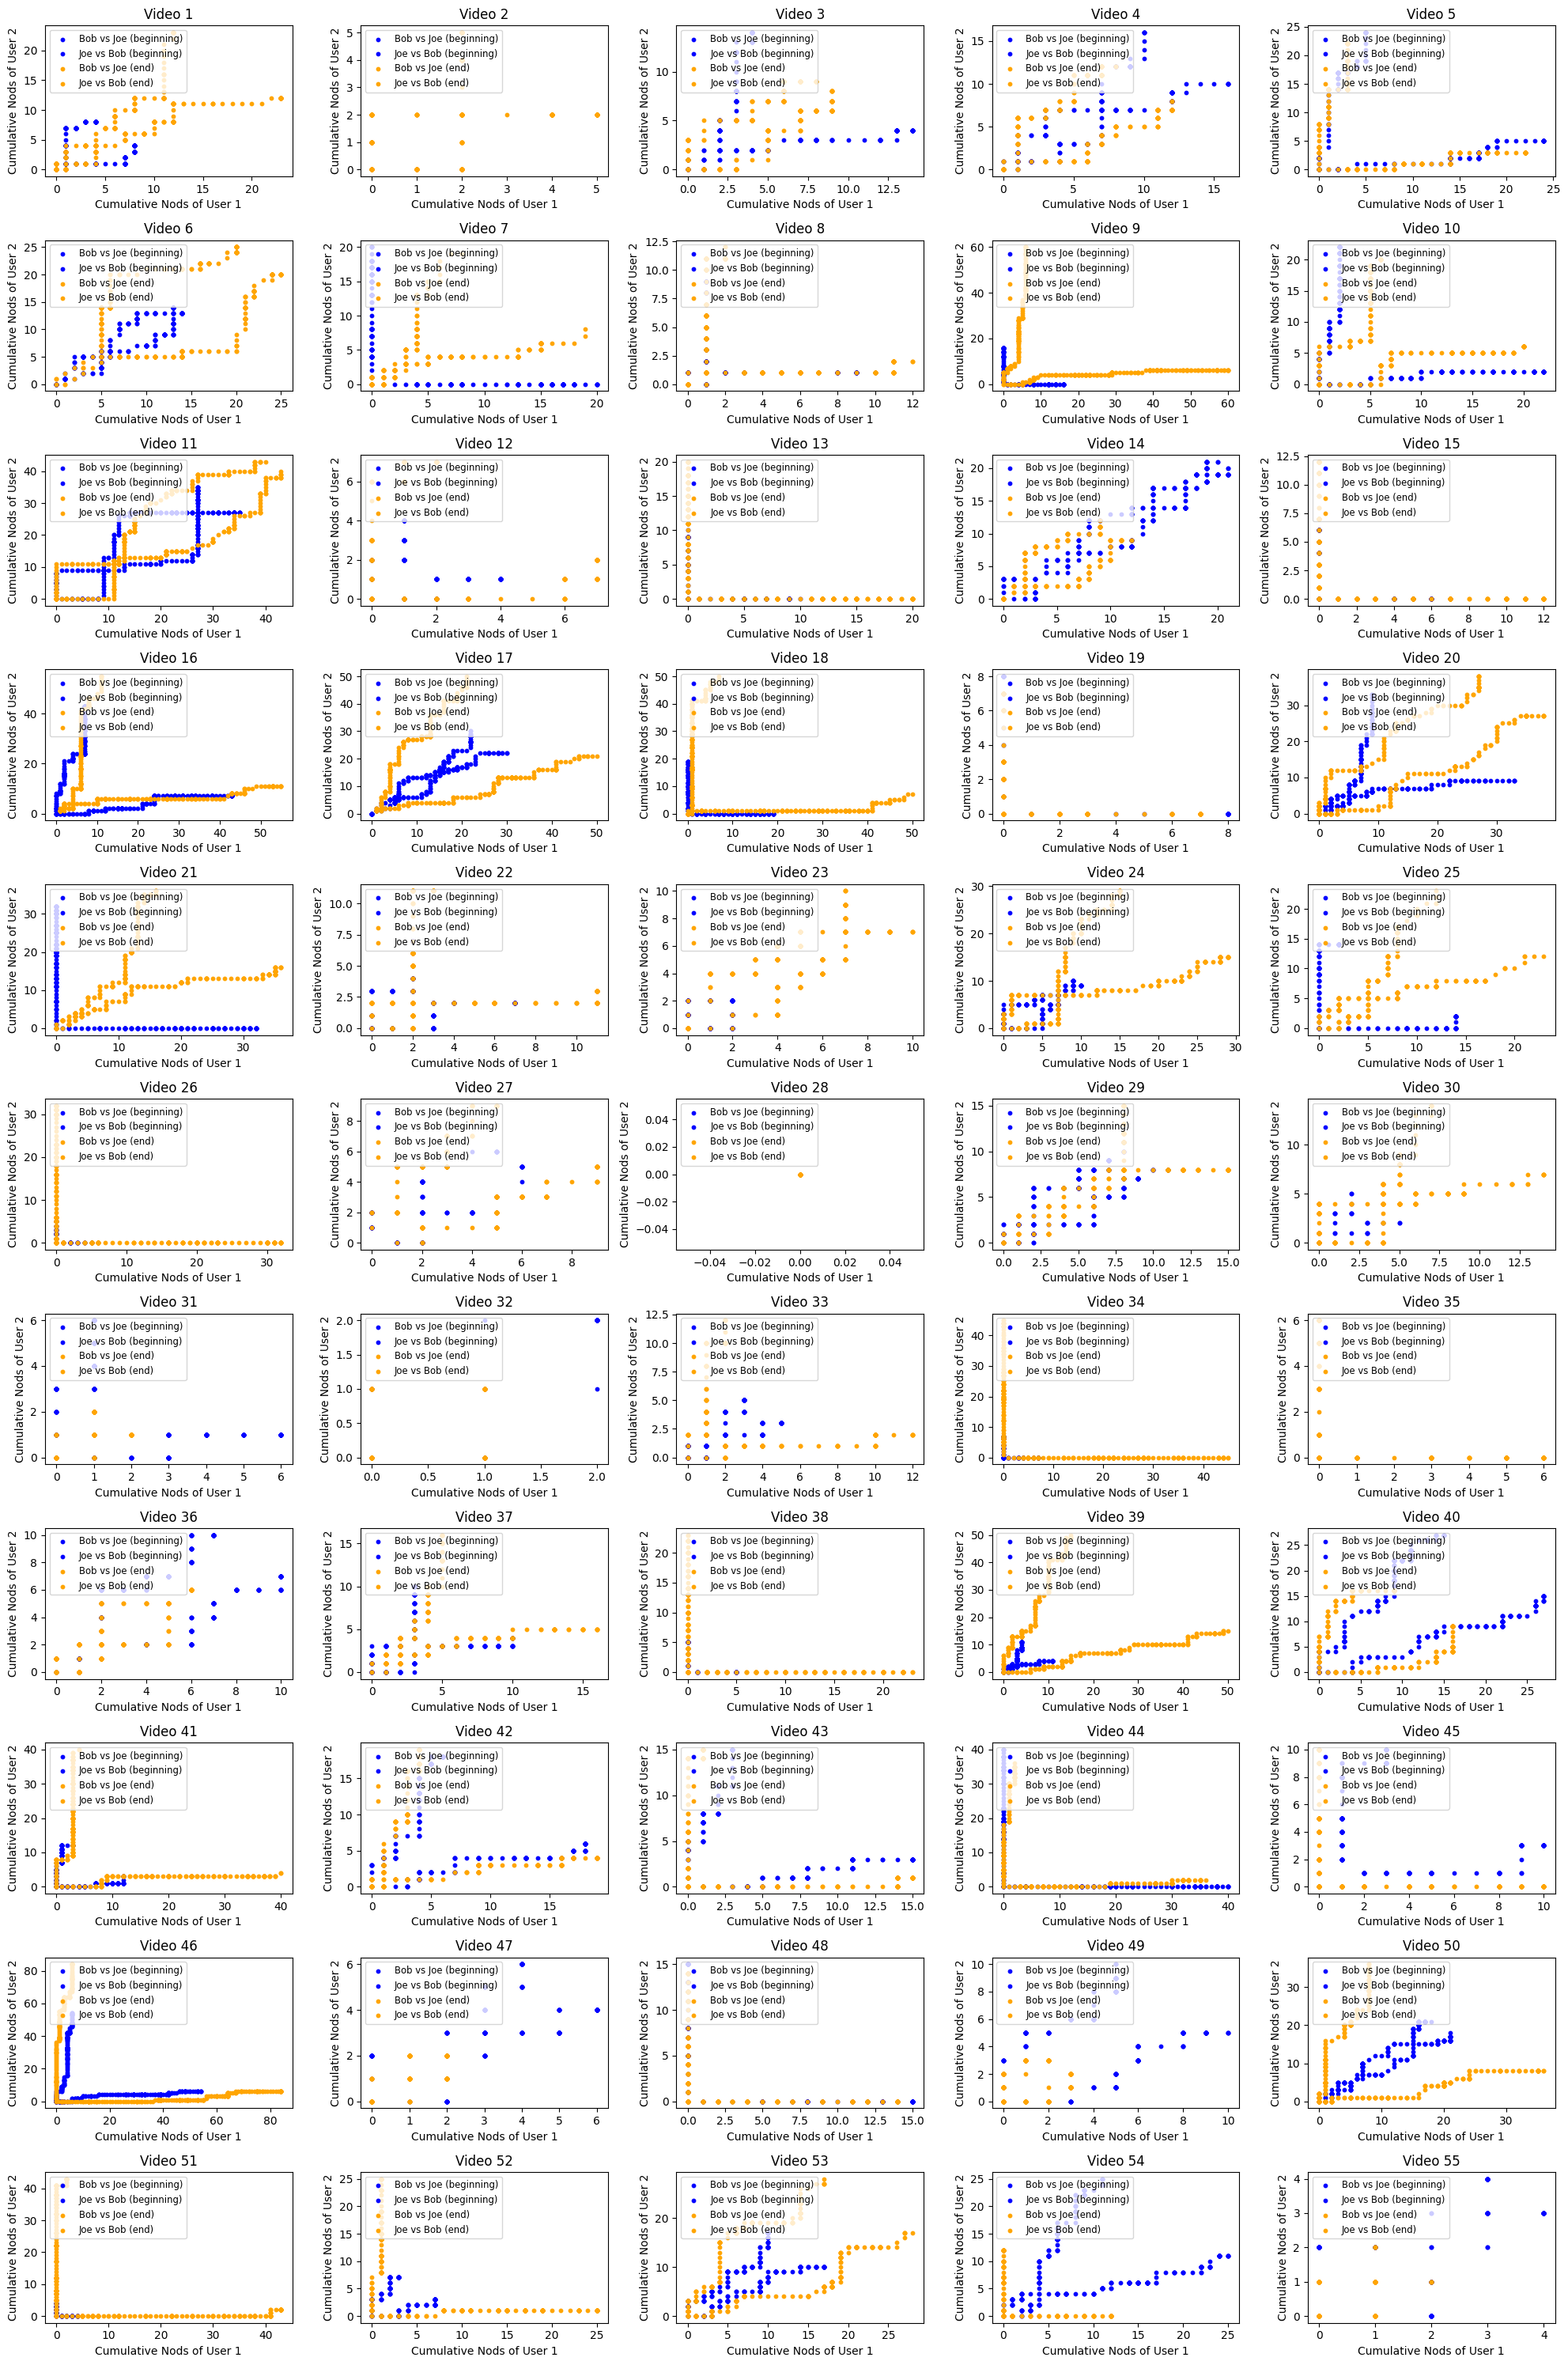

In [9]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

# Define colors for the periods
period_colors = {
    'beginning': 'blue',
    'end': 'orange'
}

fig, axes = plt.subplots(11, 5, figsize=(20, 30))
video_index = 0
colors = cm.get_cmap('tab10', 10)  # Get a colormap with 10 distinct colors

for video_data in windows_head:
    if video_index >= 55:
        break  # Ensure we do not exceed the number of subplots
    
    row = video_index // 5
    col = video_index % 5

    for period in ['beginning', 'end']:
        period_color = period_colors[period]
        users = video_data[period]['user_id']
        user_ids = np.unique(users)
        
        if len(user_ids) < 2:
            continue  # Skip this video if there are less than 2 users
        
        for i, user_id_1 in enumerate(user_ids):
            for j, user_id_2 in enumerate(user_ids):
                if i >= j:
                    continue  # Avoid duplicate plots and self-comparison
                
                user_data_1 = video_data[period][video_data[period]['user_id'] == user_id_1]
                user_data_2 = video_data[period][video_data[period]['user_id'] == user_id_2]
                
                cum_nod_yes_1 = user_data_1['cum_nod_yes']
                cum_nod_yes_2 = user_data_2['cum_nod_yes']
                
                # Ensure both users have the same number of data points
                min_len = min(len(cum_nod_yes_1), len(cum_nod_yes_2))
                cum_nod_yes_1 = cum_nod_yes_1[:min_len]
                cum_nod_yes_2 = cum_nod_yes_2[:min_len]
                
                color_1 = colors(i % 10)
                color_2 = colors(j % 10)
                
                axes[row, col].scatter(cum_nod_yes_1, cum_nod_yes_2, label=f'{user_id_1} vs {user_id_2} ({period})', color=period_color, s=10)
                axes[row, col].scatter(cum_nod_yes_2, cum_nod_yes_1, label=f'{user_id_2} vs {user_id_1} ({period})', color=period_color, s=10)
        
        axes[row, col].set_title(f'Video {video_index + 1}')
        axes[row, col].set_xlabel('Cumulative Nods of User 1')
        axes[row, col].set_ylabel('Cumulative Nods of User 2')
    
    handles, labels = axes[row, col].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[row, col].legend(by_label.values(), by_label.keys(), loc='upper left', fontsize='small')
    
    video_index += 1

plt.tight_layout()
plt.show()


# Similarity measures

In [85]:
from scipy.spatial import distance
from sklearn.metrics.cluster import rand_score

def normalize(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

def cosine_similarity(x, y):
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def jaccard(x, y):
  return distance.jaccard(x, y)

def euclidean_distance(x, y):
  return np.sqrt(np.sum(np.square(x - y)))

def jaccard_similarity(x, y):
  intersection = sum(x & y for x, y in zip(x, y))
  union = sum(x | y for x, y in zip(x, y))
  return intersection / union if union != 0 else 0

def hamming_distance(x, y):
  return sum(x != y for x, y in zip(x, y))

def pearson_correlation(x, y):
  return np.corrcoef(x, y)[0, 1]

import pandas as pd

def smc(x, y):
    m1 = [l for l in x]
    m2 = [l for l in y]

    cross = pd.crosstab(m1, m2)
    smc = 0.0  # Initialize smc with a default value
    if cross.shape == (2, 2):
        a = cross.iloc[0,0]
        b = cross.iloc[0,1]
        c = cross.iloc[1,0]
        d = cross.iloc[1,1]
        smc = (a + d) / (a + b + c + d)

    return smc

def rand(vector1, vector2):
    rand = rand_score(vector1, vector2)
    return rand

# Analysis 1 - Each window

In [86]:
metrics = ['nod_yes', 'nod_no', 'gaze_on', 'smile']
similarity_dict = {
    'nod_yes': {'beginning':[], 'end':[]},
    'nod_no': {'beginning':[], 'end':[]},
    'gaze_on': {'beginning':[], 'end':[]},
    'smile': {'beginning':[], 'end':[]}
}

In [87]:
for metric in metrics:
    for i in range(len(windows_head)):
        # Assigning video
        video = windows_head[i]
        # Beginning similarity
        vid_beginning = video['beginning']
        vid_beginning_bob = vid_beginning[vid_beginning['user_id'] == 'Bob'][metric]
        vid_beginning_joe = vid_beginning[vid_beginning['user_id'] == 'Joe'][metric]

        beginning_similarity = distance.jaccard(vid_beginning_bob, vid_beginning_joe)
        similarity_dict[metric]['beginning'].append(beginning_similarity)

        # Ending similarity
        vid_end = video['end']
        vid_end_bob = vid_end[vid_end['user_id'] == 'Bob'][metric]
        vid_end_joe = vid_end[vid_end['user_id'] == 'Joe'][metric]

        end_similarity = distance.jaccard(vid_end_bob, vid_end_joe)
        similarity_dict[metric]['end'].append(end_similarity)

In [88]:
for k, v in similarity_dict.items():
    print(k, v)

nod_yes {'beginning': [0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 0.9836065573770492, 1.0, 1.0, 0.8918918918918919, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.9444444444444444, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0.9375, 1.0, 1.0, 1.0, 0.9230769230769231, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9473684210526315, 1.0, 1.0, 0.9285714285714286, 0.8857142857142857, 1.0, 1.0, 1.0, 0.9411764705882353, 1.0], 'end': [0.9393939393939394, 1.0, 1.0, 1.0, 1.0, 0.875, 0.9615384615384616, 1.0, 0.96875, 0.96, 0.922077922077922, 1.0, 1.0, 0.95, 1.0, 0.9354838709677419, 0.9402985074626866, 0.9821428571428571, 1.0, 0.8392857142857143, 0.9387755102040817, 1.0, 1.0, 0.9767441860465116, 0.8709677419354839, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 0.984375, 1.0, 0.9767441860465116, 0.9545454545454546, 1.0, 0.972972972972973, 1.0, 0.9772727272727273, 1.0, 1.0, 1.0, 0.9523809523809523, 1.0, 0.96, 0.9285714285714286, 1.0, 1.0]}
n

In [89]:
from scipy import stats

significant_pairs = {
    'nod_yes': {'p_val': 0.0, 'mean_begin': 0.0, 'mean_end': 0.0, 'difference': 0.0},
    'nod_no': {'p_val': 0.0, 'mean_begin': 0.0, 'mean_end': 0.0, 'difference': 0.0},
    'gaze_on': {'p_val': 0.0, 'mean_begin': 0.0, 'mean_end': 0.0, 'difference': 0.0},
    'smile': {'p_val': 0.0, 'mean_begin': 0.0, 'mean_end': 0.0, 'difference': 0.0}
}

for k, v in similarity_dict.items():
    beginning_ = similarity_dict[k]['beginning']
    end_ = similarity_dict[k]['end']
    t_statistic, p_value = stats.ttest_rel(beginning_, end_)
    beginning_mean = np.mean(beginning_)
    end_mean = np.mean(end_)
    significant_pairs[k]['p_val'] = p_value
    significant_pairs[k]['mean_begin'] = beginning_mean
    significant_pairs[k]['mean_end'] = end_mean
    significant_pairs[k]['difference'] = end_mean - beginning_mean

significant_pairs

{'nod_yes': {'p_val': 0.5766162854776499,
  'mean_begin': 0.9469837817904448,
  'mean_end': 0.9577529516715702,
  'difference': 0.010769169881125307},
 'nod_no': {'p_val': 0.48950517710356456,
  'mean_begin': 0.9673469557279725,
  'mean_end': 0.9806283487154838,
  'difference': 0.013281392987511298},
 'gaze_on': {'p_val': 0.7042639019583391,
  'mean_begin': 0.7970082651369301,
  'mean_end': 0.7832258734540792,
  'difference': -0.013782391682850892},
 'smile': {'p_val': 0.16283595224803457,
  'mean_begin': 0.8338439091780401,
  'mean_end': 0.7944445732456863,
  'difference': -0.039399335932353785}}

In [90]:
sif_pair_df = pd.DataFrame(significant_pairs)
sif_pair_df

nod_yes    nod_no   gaze_on     smile
p_val       0.576616  0.489505  0.704264  0.162836
mean_begin  0.946984  0.967347  0.797008  0.833844
mean_end    0.957753  0.980628  0.783226  0.794445
difference  0.010769  0.013281 -0.013782 -0.039399

## Plot yes

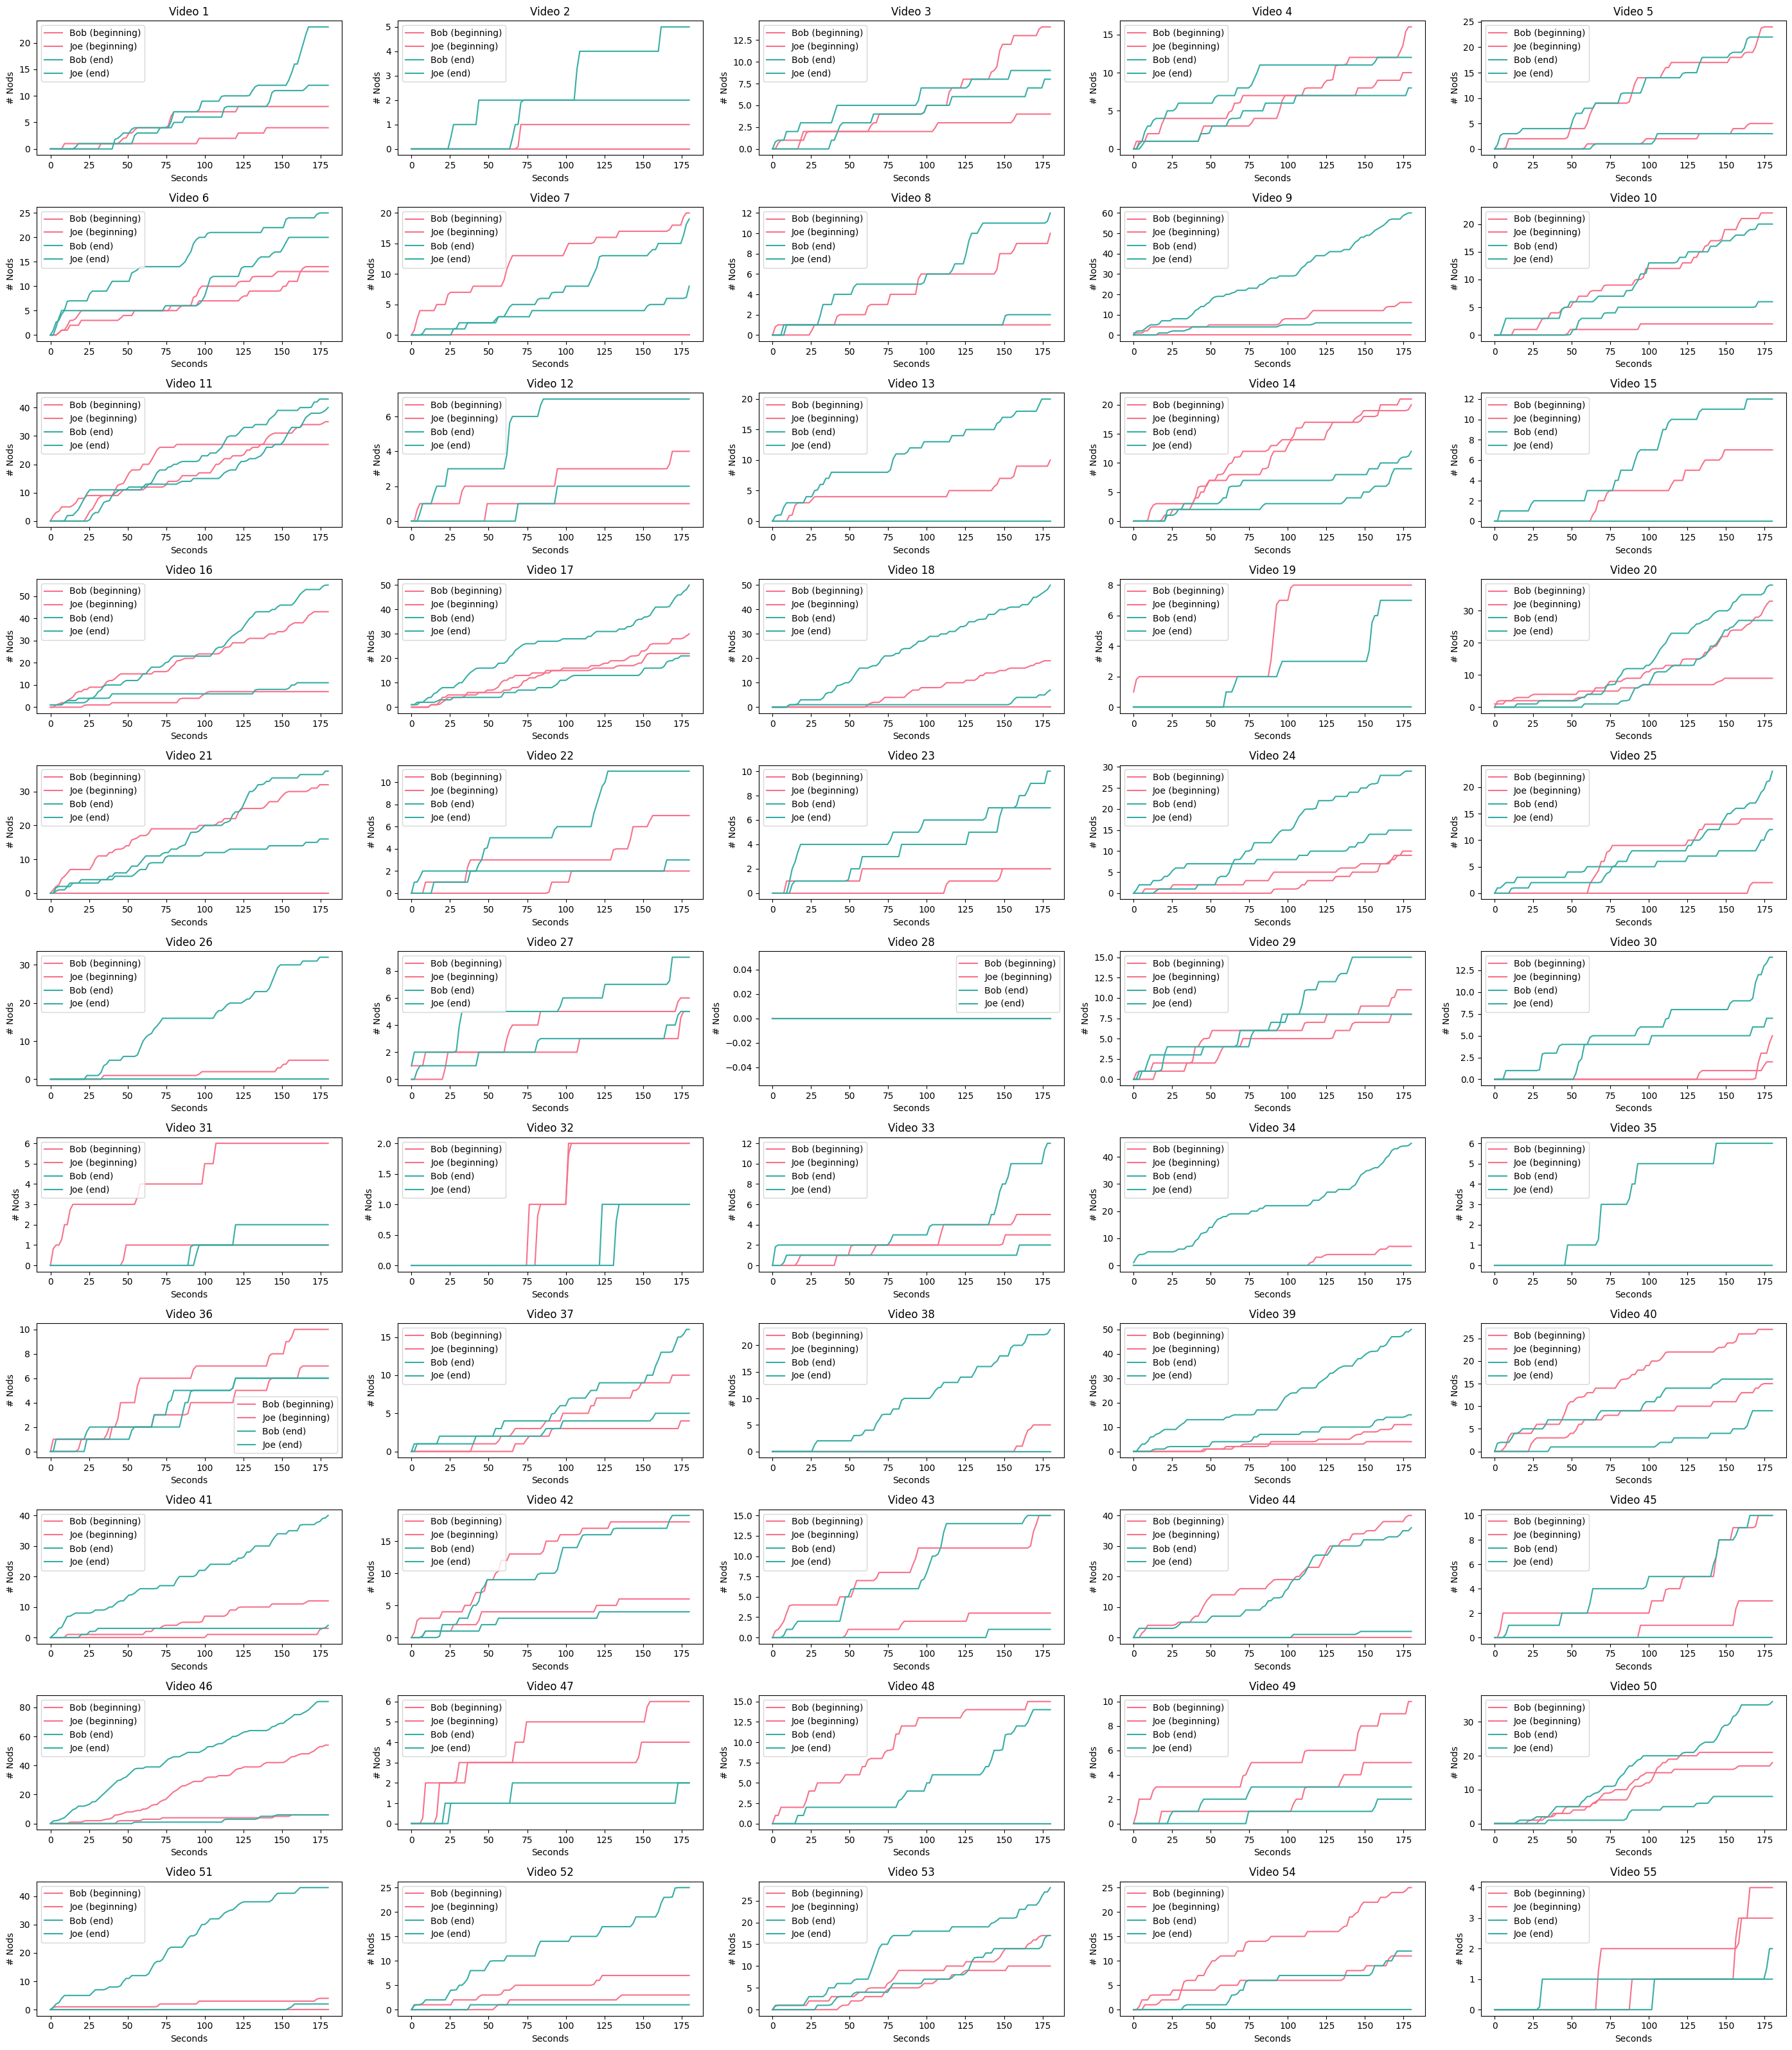

In [15]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import math

fig, axes = plt.subplots(math.ceil(len(windows_head) / 5), 5, figsize=(28, 32), squeeze=False)
periods = ['beginning', 'end']
videos = windows_head
colors = sns.color_palette('husl', len(periods))
period_colors = {periods[p]: colors[p] for p in range(len(periods))}

for i, v in enumerate(videos):
    row, col = i // 5, i % 5
    for p in range(len(periods)):
        this_v = v[periods[p]]
        color = period_colors[periods[p]]
        for u in this_v['user_id'].unique():
            nod_yes_cumsum = np.cumsum(this_v[this_v['user_id'] == u]['nod_yes'].fillna(0))
            seconds = [s for s in range(len(this_v[this_v['user_id'] == u]['seconds']))]
            smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
            f = interp1d(seconds, nod_yes_cumsum, kind='linear')
            smooth_nod_yes_cumsum = f(smooth_seconds)
            label = f'{u} ({periods[p]})'
            axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=label, color=color)
            axes[row, col].set_title(f'Video {i+1}')
            axes[row, col].set_xlabel('Seconds')
            axes[row, col].set_ylabel('# Nods')
            axes[row, col].legend()

plt.tight_layout()
plt.show()

## Plot no

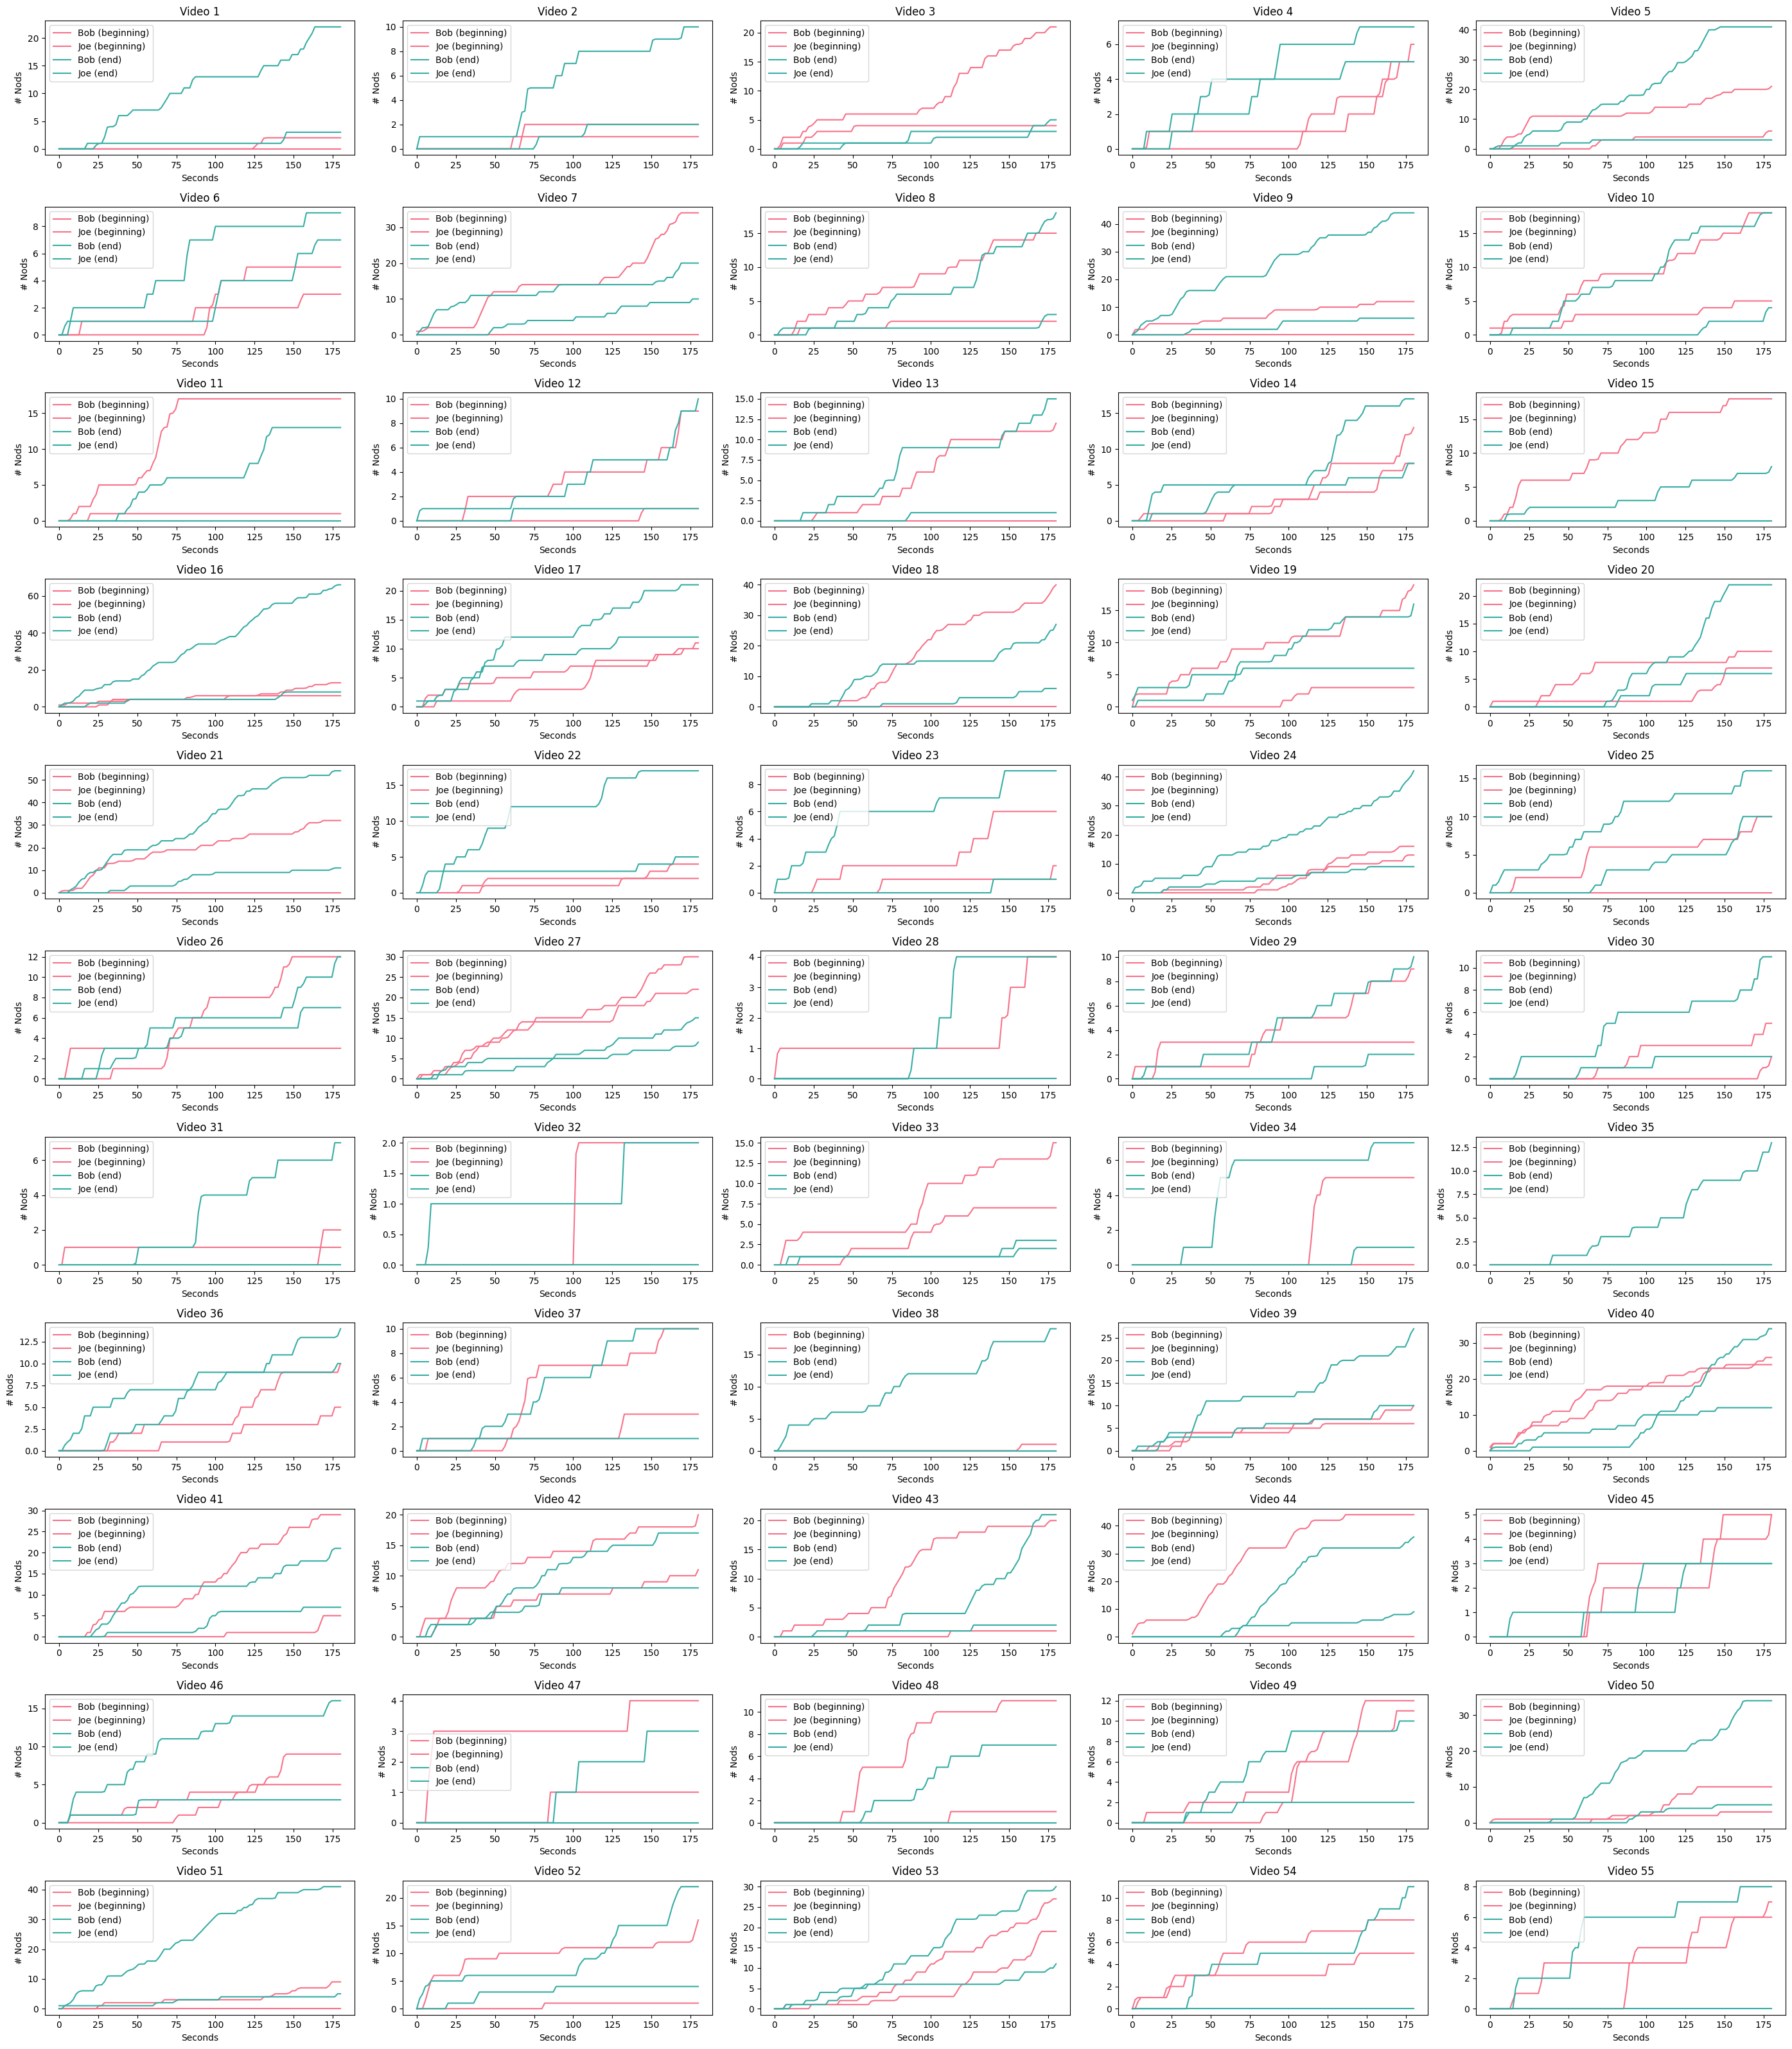

In [16]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import math

fig, axes = plt.subplots(math.ceil(len(windows_head) / 5), 5, figsize=(28, 32), squeeze=False)
periods = ['beginning', 'end']
videos = windows_head
colors = sns.color_palette('husl', len(periods))
period_colors = {periods[p]: colors[p] for p in range(len(periods))}

for i, v in enumerate(videos):
    row, col = i // 5, i % 5
    for p in range(len(periods)):
        this_v = v[periods[p]]
        color = period_colors[periods[p]]
        for u in this_v['user_id'].unique():
            nod_yes_cumsum = np.cumsum(this_v[this_v['user_id'] == u]['nod_no'].fillna(0))
            seconds = [s for s in range(len(this_v[this_v['user_id'] == u]['seconds']))]
            smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
            f = interp1d(seconds, nod_yes_cumsum, kind='linear')
            smooth_nod_yes_cumsum = f(smooth_seconds)
            label = f'{u} ({periods[p]})'
            axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=label, color=color)
            axes[row, col].set_title(f'Video {i+1}')
            axes[row, col].set_xlabel('Seconds')
            axes[row, col].set_ylabel('# Nods')
            axes[row, col].legend()

plt.tight_layout()
plt.show()

# Gaze on

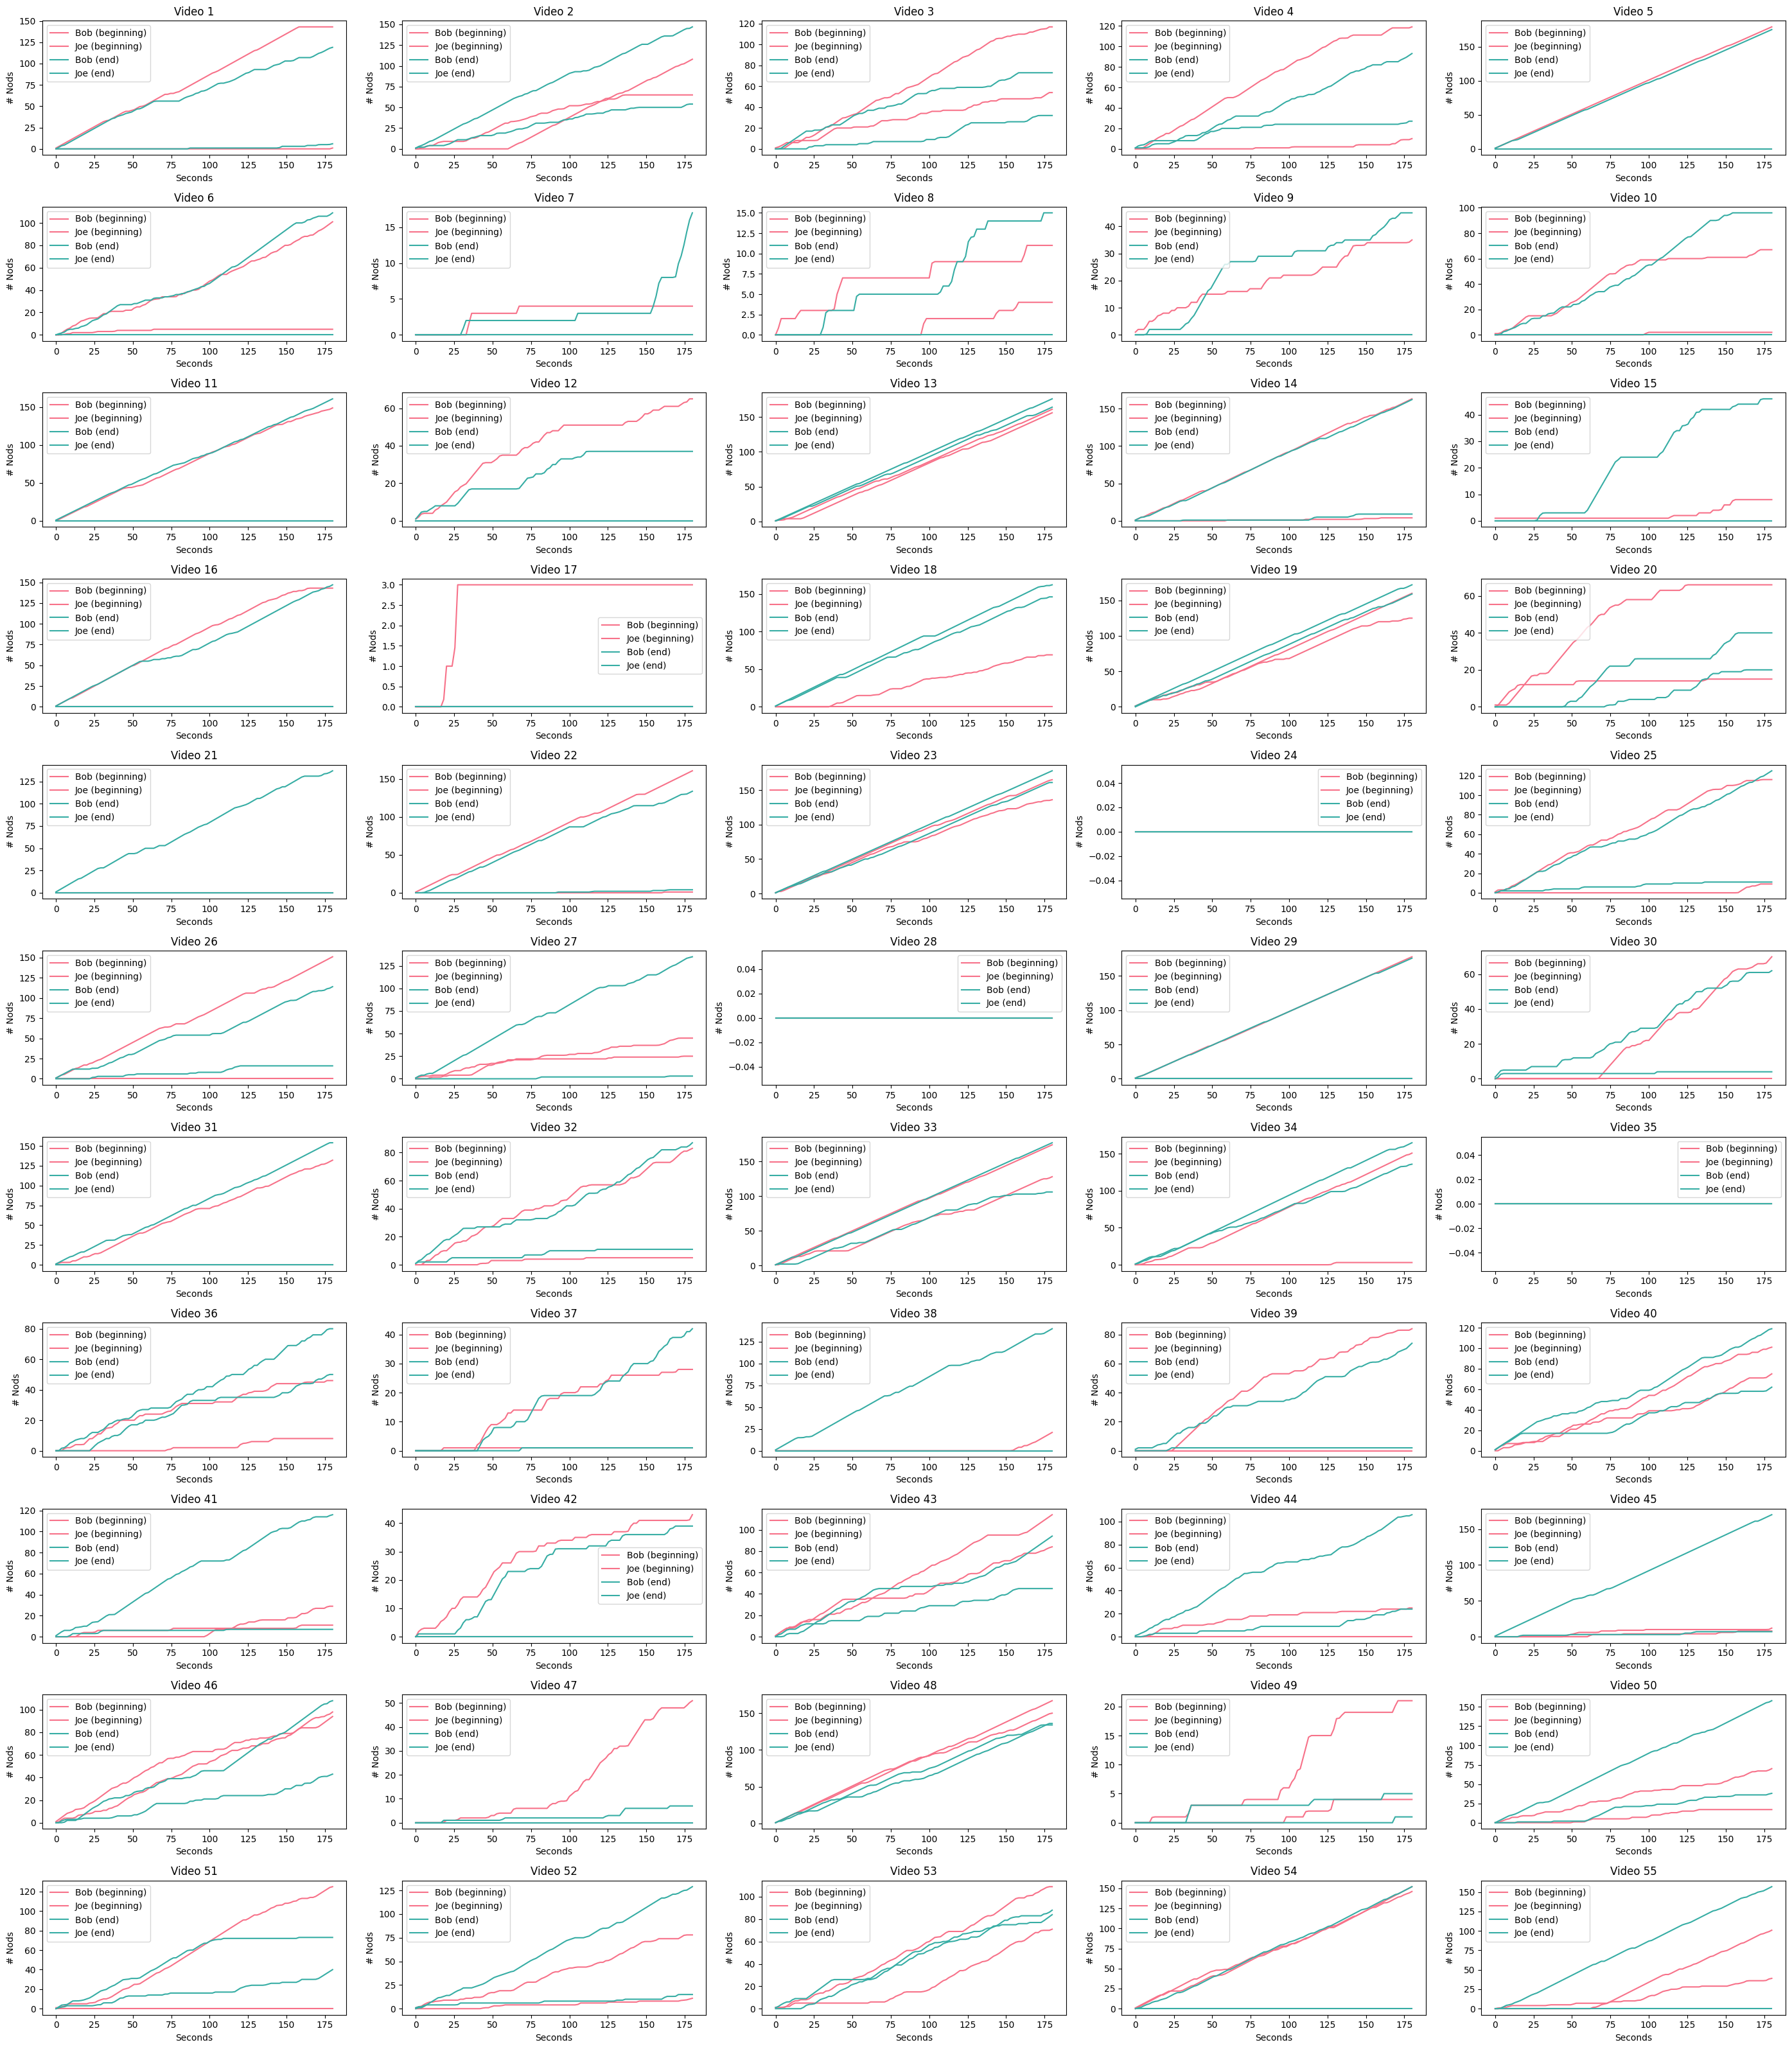

In [17]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import math

fig, axes = plt.subplots(math.ceil(len(windows_head) / 5), 5, figsize=(28, 32), squeeze=False)
periods = ['beginning', 'end']
videos = windows_head
colors = sns.color_palette('husl', len(periods))
period_colors = {periods[p]: colors[p] for p in range(len(periods))}

for i, v in enumerate(videos):
    row, col = i // 5, i % 5
    for p in range(len(periods)):
        this_v = v[periods[p]]
        color = period_colors[periods[p]]
        for u in this_v['user_id'].unique():
            nod_yes_cumsum = np.cumsum(this_v[this_v['user_id'] == u]['gaze_on'].fillna(0))
            seconds = [s for s in range(len(this_v[this_v['user_id'] == u]['seconds']))]
            smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
            f = interp1d(seconds, nod_yes_cumsum, kind='linear')
            smooth_nod_yes_cumsum = f(smooth_seconds)
            label = f'{u} ({periods[p]})'
            axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=label, color=color)
            axes[row, col].set_title(f'Video {i+1}')
            axes[row, col].set_xlabel('Seconds')
            axes[row, col].set_ylabel('# Nods')
            axes[row, col].legend()

plt.tight_layout()
plt.show()

## Smile

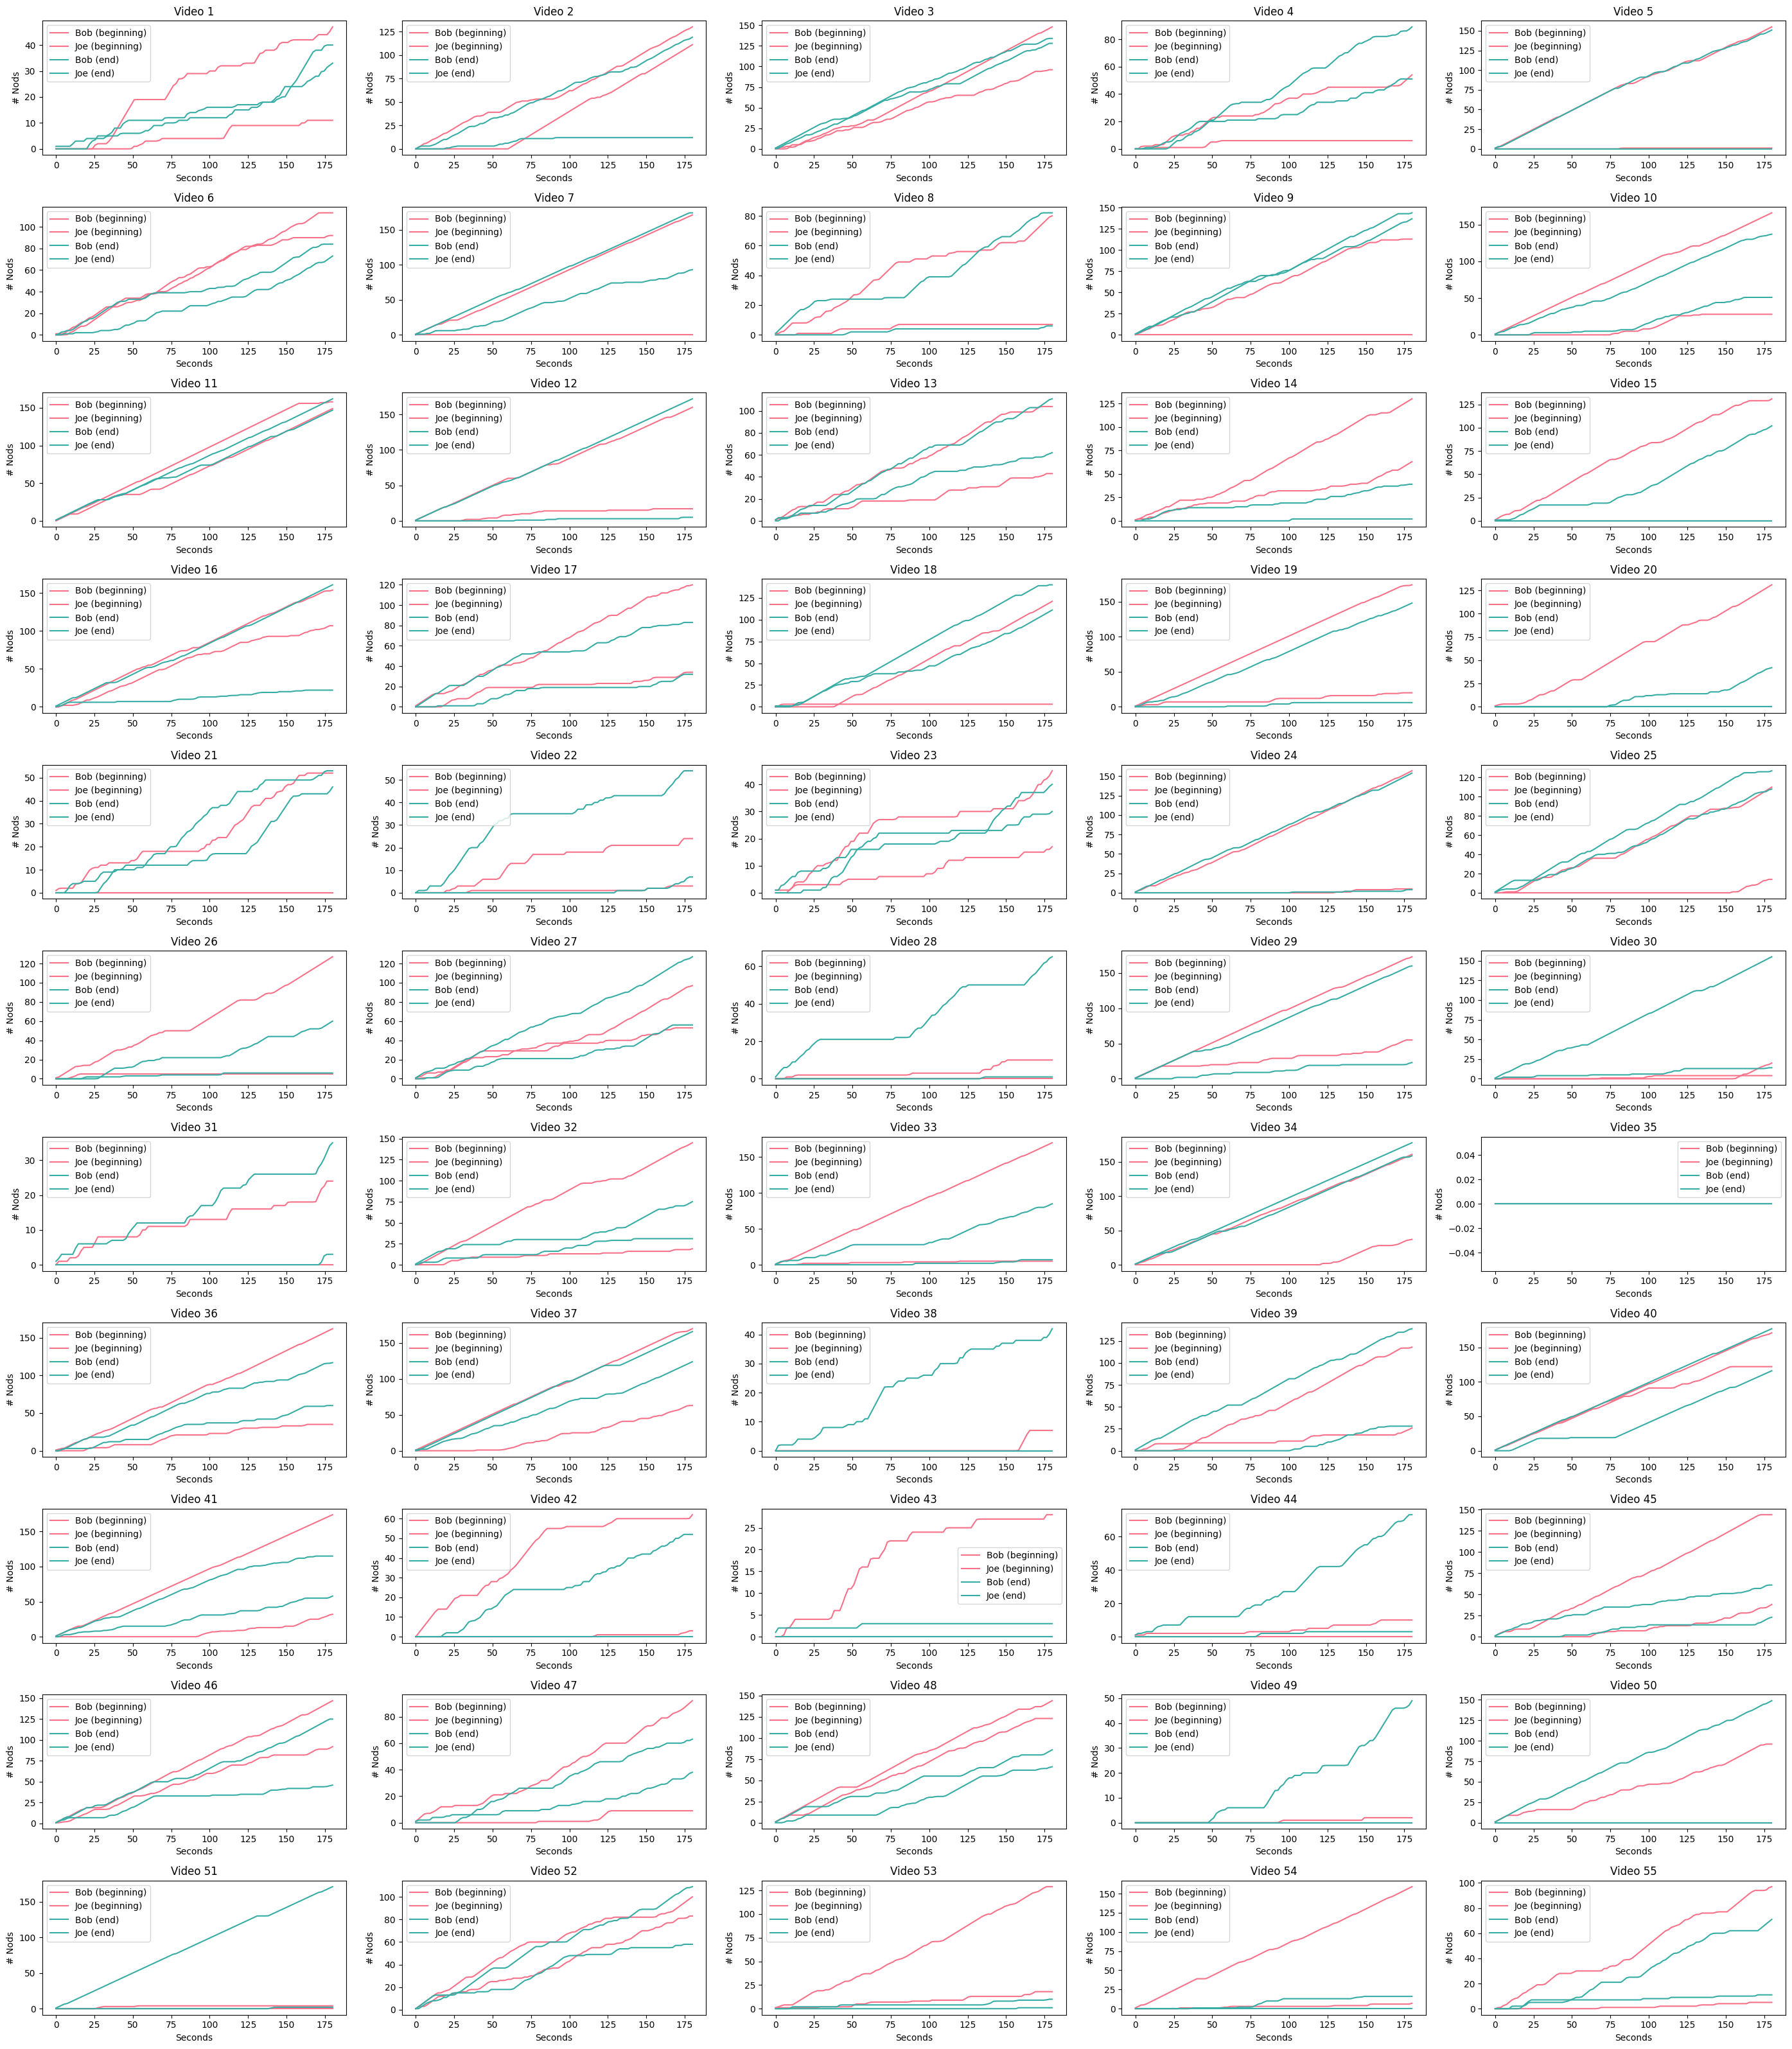

In [18]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import math

fig, axes = plt.subplots(math.ceil(len(windows_head) / 5), 5, figsize=(28, 32), squeeze=False)
periods = ['beginning', 'end']
videos = windows_head
colors = sns.color_palette('husl', len(periods))
period_colors = {periods[p]: colors[p] for p in range(len(periods))}

for i, v in enumerate(videos):
    row, col = i // 5, i % 5
    for p in range(len(periods)):
        this_v = v[periods[p]]
        color = period_colors[periods[p]]
        for u in this_v['user_id'].unique():
            nod_yes_cumsum = np.cumsum(this_v[this_v['user_id'] == u]['smile'].fillna(0))
            seconds = [s for s in range(len(this_v[this_v['user_id'] == u]['seconds']))]
            smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
            f = interp1d(seconds, nod_yes_cumsum, kind='linear')
            smooth_nod_yes_cumsum = f(smooth_seconds)
            label = f'{u} ({periods[p]})'
            axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=label, color=color)
            axes[row, col].set_title(f'Video {i+1}')
            axes[row, col].set_xlabel('Seconds')
            axes[row, col].set_ylabel('# Nods')
            axes[row, col].legend()

plt.tight_layout()
plt.show()

# Hypothesis Testing

In [19]:
metrics = ['gaze_on', 'nod_yes', 'nod_no', 'smile']
from scipy.stats import chi2_contingency
from collections import defaultdict

In [20]:
correlation_stats_internal = {
    'beginning': defaultdict(lambda: defaultdict(int)),
    'end': defaultdict(lambda: defaultdict(int))
}

def analyze_correlation(video, metric1, metric2, vid_idx, period):
    metric_s1 = [label for label in video[period][video[period]['user_id'] == 'Bob'][metric1]]
    metric_s2 = [label for label in video[period][video[period]['user_id'] == 'Joe'][metric2]]
    data = pd.DataFrame({'metric_s1': metric_s1, 'metric_s2': metric_s2})
    contingency_table = pd.crosstab(data['metric_s1'], data['metric_s2'], dropna=False)
    chi2, p_val, _, _ = chi2_contingency(contingency_table, correction=True)

    # Determine significance
    if p_val < 0.05:
        measurement = f'{metric1}_{metric2}'
        significance = 'significant'
        correlation_stats_internal[period][measurement][significance] += 1

        a = contingency_table.iloc[0, 0]
        b = contingency_table.iloc[0, 1]
        c = contingency_table.iloc[1, 0]
        d = contingency_table.iloc[1, 1]

        if (np.sqrt((a + b) * (c + d) * (a + c) * (b + d))) != 0:
            phi_coefficient = (a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
        
            if phi_coefficient > 0.2 or phi_coefficient < -0.2:
                if metric1 == metric2:
                    
                    print(f'MEASUREMENT: {measurement} - Period: {period}')
                    print(f"Phi Coefficient: {phi_coefficient}")
                    print(f"Video Index: {vid_idx}")
        else:
            measurement = f'{metric1}_{metric2}'
            significance = 'not_significant'
            correlation_stats_internal[period][measurement][significance] += 1

In [21]:
metrics = ['gaze_on', 'nod_yes', 'nod_no', 'smile']
count_matrix_beginning = np.zeros((len(metrics), len(metrics)), dtype=int)
count_matrix_end = np.zeros((len(metrics), len(metrics)), dtype=int)
periods = ['beginning', 'end']
for idx, video in enumerate(windows_head):
    for period in periods:
        for i, metric1 in enumerate(metrics):
            for j, metric2 in enumerate(metrics):
                    analyze_correlation(video, metric1, metric2, idx, period)
                    if period == 'beginning':
                        count_matrix_beginning[i, j] = correlation_stats_internal[period][f'{metric1}_{metric2}']['significant']
                    else:
                        count_matrix_end[i, j] = correlation_stats_internal[period][f'{metric1}_{metric2}']['significant']

MEASUREMENT: gaze_on_gaze_on - Period: beginning
Phi Coefficient: -0.20622349534918327
Video Index: 1
MEASUREMENT: gaze_on_gaze_on - Period: end
Phi Coefficient: -0.2038771630902416
Video Index: 2
MEASUREMENT: nod_no_nod_no - Period: end
Phi Coefficient: 0.24606510690332836
Video Index: 7
MEASUREMENT: smile_smile - Period: beginning
Phi Coefficient: -0.25933372949401423
Video Index: 9
MEASUREMENT: smile_smile - Period: end
Phi Coefficient: 0.240436391789281
Video Index: 9
MEASUREMENT: gaze_on_gaze_on - Period: end
Phi Coefficient: 0.2924002618572896
Video Index: 12
MEASUREMENT: smile_smile - Period: end
Phi Coefficient: 0.23852720053732693
Video Index: 12
MEASUREMENT: nod_no_nod_no - Period: beginning
Phi Coefficient: 0.21489258055787125
Video Index: 23
MEASUREMENT: smile_smile - Period: beginning
Phi Coefficient: -0.24307051217168962
Video Index: 35
MEASUREMENT: smile_smile - Period: beginning
Phi Coefficient: -0.2995857082390748
Video Index: 36


# Recurrence Analysis

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def cross_recurrence_plot(x, y, radius=0.2, metric='jaccard'):
    distances = np.zeros((len(x), len(y)))
    crp = np.zeros_like(distances, dtype=bool)

    for i in range(len(x)):
        for j in range(len(y)):
            if metric == 'jaccard':
                intersection = np.sum(np.logical_and(x[i], y[j]))
                union = np.sum(np.logical_or(x[i], y[j]))
                distance = intersection / union
            else:
                raise ValueError(f"Invalid distance metric: {metric}")

            distances[i, j] = distance
            crp[i, j] = distance <= radius

    return crp

def crp_measures(crp):
    measures = {}

    # Recurrence rate (RR)
    measures['rr'] = np.sum(crp) / (crp.size)

    # Determinism (DET)
    diag_lines = np.zeros_like(crp, dtype=int)
    for i in range(crp.shape[0]):
        for j in range(crp.shape[1]):
            if crp[i, j]:
                diag_lines[i, j] = np.diag(crp[:, j:], k=i).sum()

    diag_lines = diag_lines[diag_lines > 0]
    if diag_lines.size > 0:
        measures['det'] = np.sum(diag_lines ** 2) / np.sum(diag_lines)
        measures['lmax'] = np.max(diag_lines)
    else:
        measures['det'] = 0
        measures['lmax'] = 0

    return measures


behavior_data = []

for window, video_index in zip(windows_head, range(len(windows_head))):
    beginning = window['beginning']
    end = window['end']

    for metric in ['nod_yes', 'nod_no', 'gaze_on', 'smile']:
        bob_beginning = beginning[beginning['user_id'] == 'Bob'][metric].values
        joe_beginning = beginning[beginning['user_id'] == 'Joe'][metric].values

        bob_end = end[end['user_id'] == 'Bob'][metric].values
        joe_end = end[end['user_id'] == 'Joe'][metric].values

        crp_beginning = cross_recurrence_plot(bob_beginning, joe_beginning)
        crp_measures_beginning = crp_measures(crp_beginning)

        crp_end = cross_recurrence_plot(bob_end, joe_end)
        crp_measures_end = crp_measures(crp_end)

        behavior_data.append({
            'Video_Index': video_index,
            'Metric': metric,
            'Window': 'Beginning',
            'RR': crp_measures_beginning['rr'],
            'DET': crp_measures_beginning['det'],
            'LMAX': crp_measures_beginning['lmax']
        })

        behavior_data.append({
            'Video_Index': video_index,
            'Metric': metric,
            'Window': 'End',
            'RR': crp_measures_end['rr'],
            'DET': crp_measures_end['det'],
            'LMAX': crp_measures_end['lmax']
        })

behavior_df = pd.DataFrame(behavior_data)


/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/4030825281.py:22: RuntimeWarning: invalid value encountered in scalar divide
  distance = intersection / union


In [78]:
average_df = behavior_df.groupby(['Metric', 'Window']).mean().reset_index()
beginning_avg_df = average_df[average_df['Window'] == 'Beginning'].rename(columns={'RR': 'RR_beginning', 'LMAX': 'LMAX_beginning'})
end_avg_df = average_df[average_df['Window'] == 'End'].rename(columns={'RR': 'RR_end', 'LMAX': 'LMAX_end'})
merged_avg_df = beginning_avg_df.merge(end_avg_df, on='Metric')
merged_avg_df['RR_diff'] = merged_avg_df['RR_end'] - merged_avg_df['RR_beginning']
merged_avg_df['LMAX_diff'] = merged_avg_df['LMAX_end'] - merged_avg_df['LMAX_beginning']
new_avg_df = merged_avg_df[['Metric', 'RR_beginning', 'RR_end', 'RR_diff', 'LMAX_beginning', 'LMAX_end', 'LMAX_diff']]
new_avg_df

Metric  RR_beginning    RR_end   RR_diff  LMAX_beginning   LMAX_end  \
0  gaze_on      0.406671  0.470539  0.063868       74.472727  85.690909   
1   nod_no      0.092812  0.119810  0.026998       16.618182  21.872727   
2  nod_yes      0.099714  0.146557  0.046843       18.072727  26.745455   
3    smile      0.500571  0.458140 -0.042431       91.709091  84.000000   

   LMAX_diff  
0  11.218182  
1   5.254545  
2   8.672727  
3  -7.709091

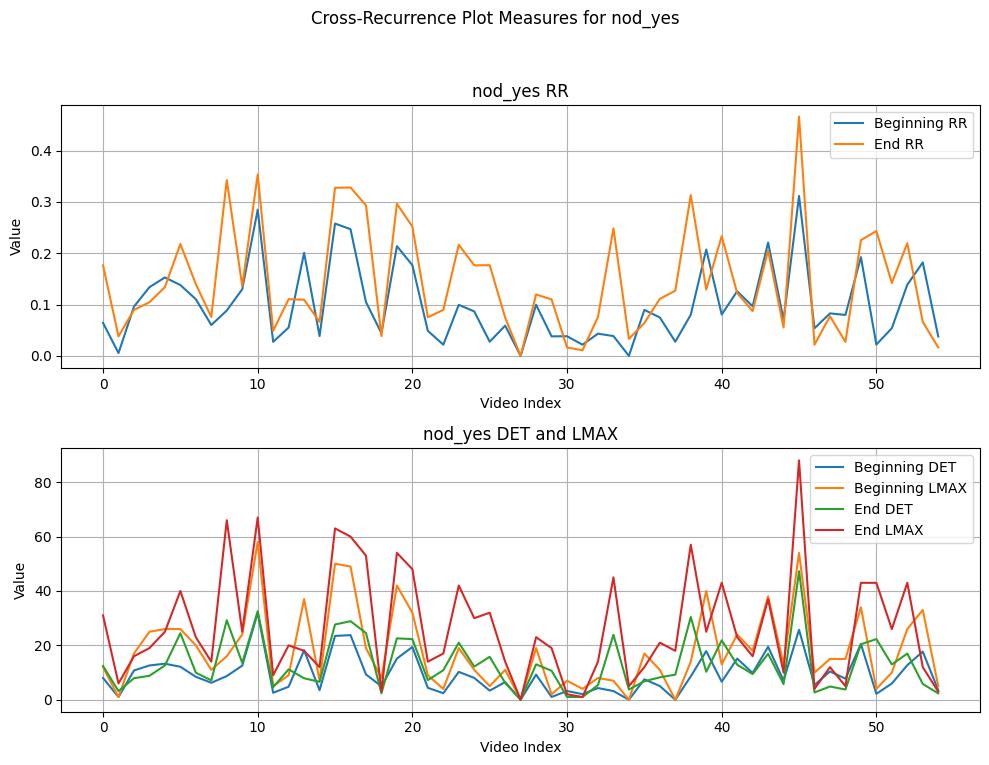

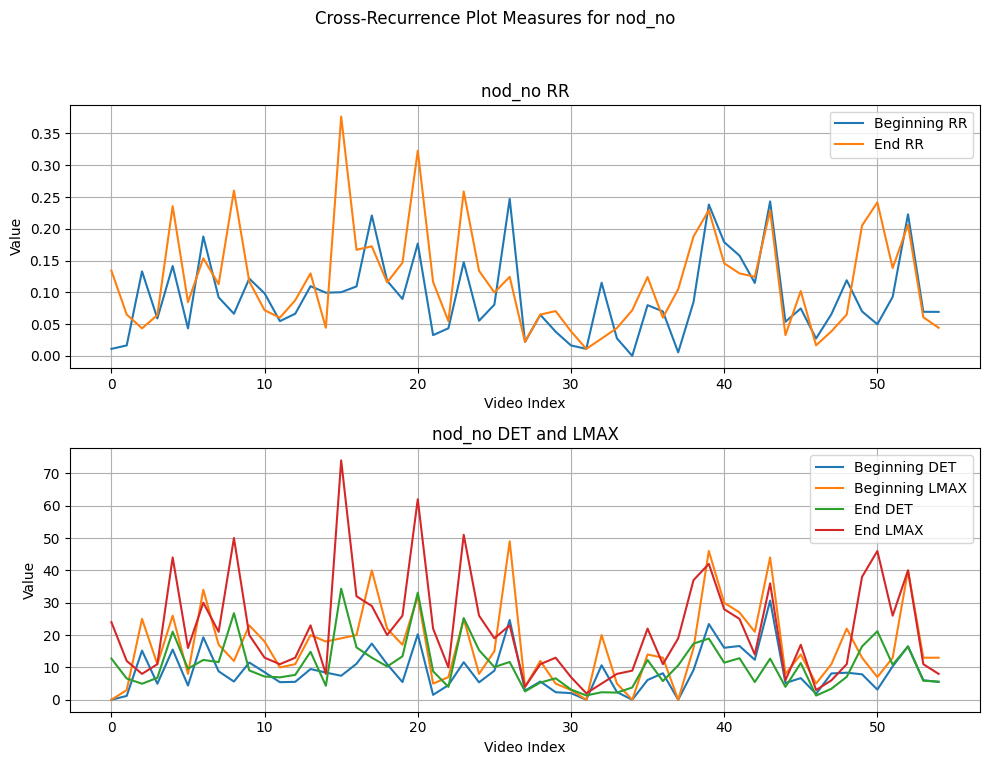

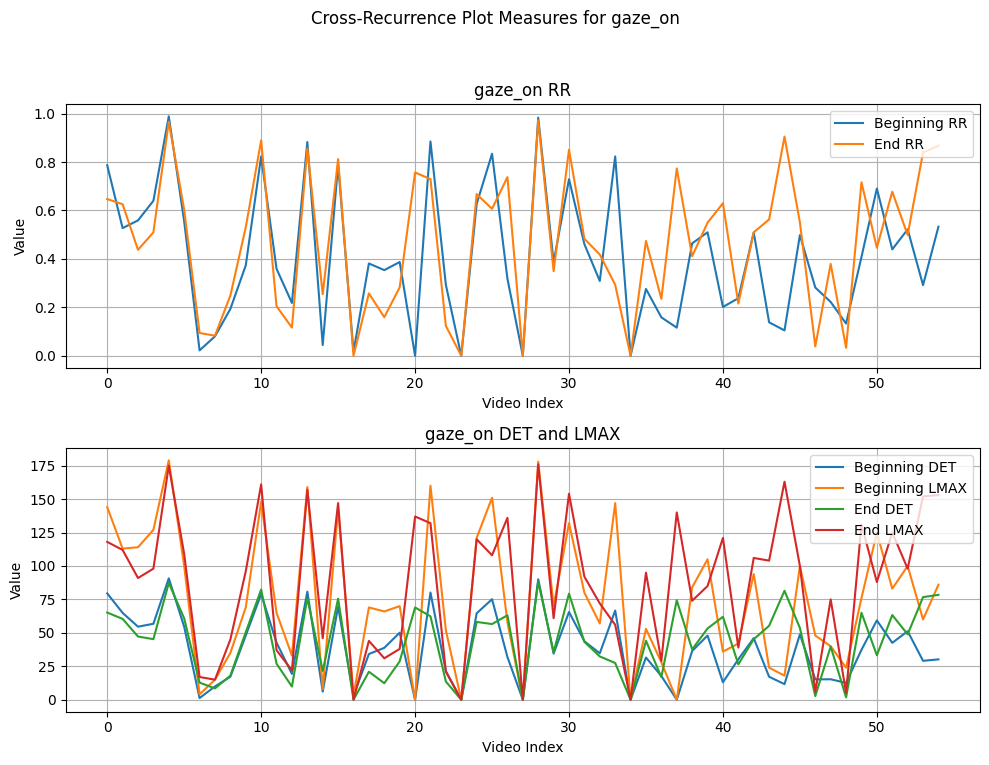

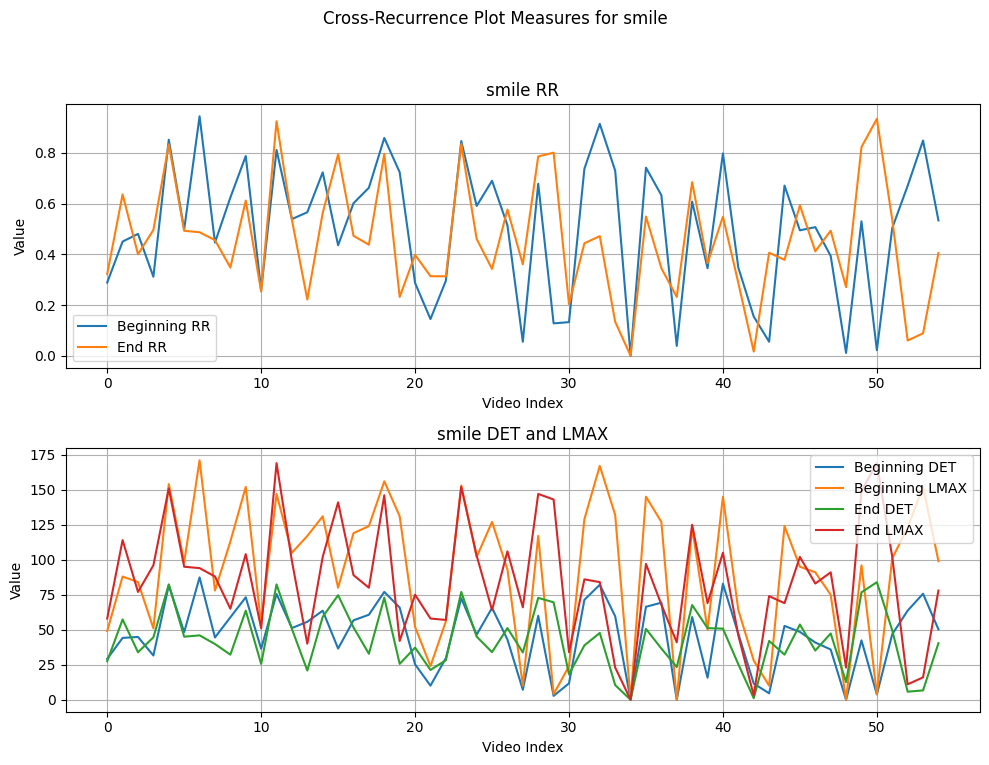

In [23]:
metrics = behavior_df['Metric'].unique()

for metric in metrics:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
    fig.suptitle(f'Cross-Recurrence Plot Measures for {metric}')

    ax1 = axes[0]
    ax1.set_title(f'{metric} RR')
    for window in ['Beginning', 'End']:
        df = behavior_df[(behavior_df['Metric'] == metric) & (behavior_df['Window'] == window)]
        ax1.plot(df['Video_Index'], df['RR'], label=f'{window} RR')
    ax1.set_xlabel('Video Index')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True)

    ax2 = axes[1]
    ax2.set_title(f'{metric} DET and LMAX')
    for window in ['Beginning', 'End']:
        df = behavior_df[(behavior_df['Metric'] == metric) & (behavior_df['Window'] == window)]
        ax2.plot(df['Video_Index'], df['DET'], label=f'{window} DET')
        ax2.plot(df['Video_Index'], df['LMAX'], label=f'{window} LMAX')
    ax2.set_xlabel('Video Index')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualization

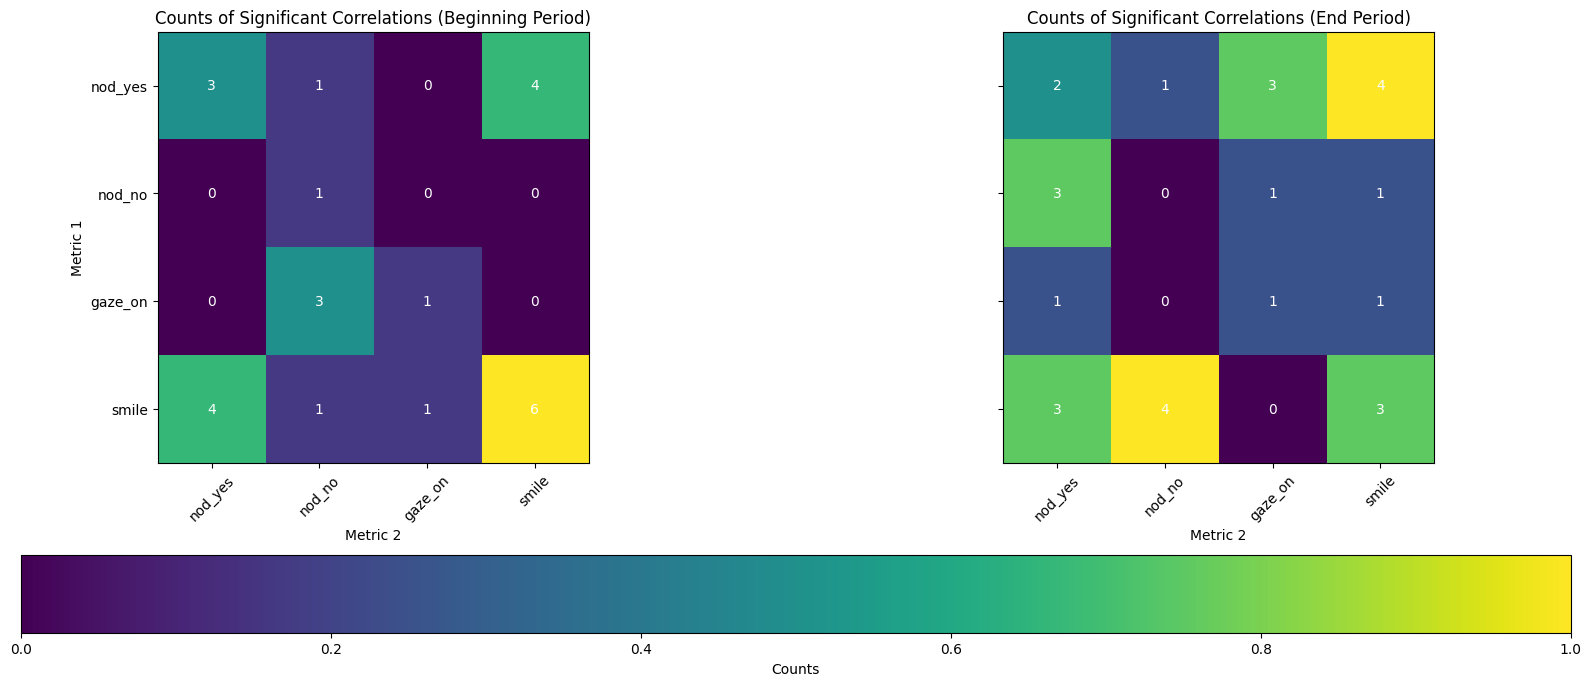

In [24]:
import matplotlib.pyplot as plt

# Create subplots for both periods
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plotting for the 'beginning' period
axes[0].imshow(count_matrix_beginning, cmap='viridis', interpolation='nearest')
axes[0].set_xticks(np.arange(len(metrics)))
axes[0].set_yticks(np.arange(len(metrics)))
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].set_yticklabels(metrics)
axes[0].set_xlabel('Metric 2')
axes[0].set_ylabel('Metric 1')
axes[0].set_title('Counts of Significant Correlations (Beginning Period)')

# Add annotations for the 'beginning' period
for i in range(len(metrics)):
    for j in range(len(metrics)):
        axes[0].text(j, i, count_matrix_beginning[i, j], ha='center', va='center', color='white')

# Plotting for the 'end' period
axes[1].imshow(count_matrix_end, cmap='viridis', interpolation='nearest')
axes[1].set_xticks(np.arange(len(metrics)))
axes[1].set_yticks(np.arange(len(metrics)))
axes[1].set_xticklabels(metrics, rotation=45)
axes[1].set_yticklabels([])
axes[1].set_xlabel('Metric 2')
axes[1].set_title('Counts of Significant Correlations (End Period)')

# Add annotations for the 'end' period
for i in range(len(metrics)):
    for j in range(len(metrics)):
        axes[1].text(j, i, count_matrix_end[i, j], ha='center', va='center', color='white')

# Add colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes.ravel().tolist(), orientation='horizontal')
cbar.set_label('Counts')

plt.show()


# Printing

In [25]:
for key, val in correlation_stats_internal.items():
    print(key)
    for k, v in val.items():
        print(f'{k}: {v}')

beginning
gaze_on_gaze_on: defaultdict(<class 'int'>, {'significant': 3})
gaze_on_nod_yes: defaultdict(<class 'int'>, {'significant': 1})
gaze_on_nod_no: defaultdict(<class 'int'>, {'significant': 0})
gaze_on_smile: defaultdict(<class 'int'>, {'significant': 4})
nod_yes_gaze_on: defaultdict(<class 'int'>, {'significant': 0})
nod_yes_nod_yes: defaultdict(<class 'int'>, {'significant': 1})
nod_yes_nod_no: defaultdict(<class 'int'>, {'significant': 0})
nod_yes_smile: defaultdict(<class 'int'>, {'significant': 0})
nod_no_gaze_on: defaultdict(<class 'int'>, {'significant': 0})
nod_no_nod_yes: defaultdict(<class 'int'>, {'significant': 3})
nod_no_nod_no: defaultdict(<class 'int'>, {'significant': 1})
nod_no_smile: defaultdict(<class 'int'>, {'significant': 0})
smile_gaze_on: defaultdict(<class 'int'>, {'significant': 4})
smile_nod_yes: defaultdict(<class 'int'>, {'significant': 1})
smile_nod_no: defaultdict(<class 'int'>, {'significant': 1})
smile_smile: defaultdict(<class 'int'>, {'signific

# McNemar Test

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from statsmodels.stats.contingency_tables import mcnemar
from collections import Counter
import numpy as np

def visualize_jaccard_similarity(windows_head):
    jaccard_data = []
    periods = ['beginning', 'end']

    for i, video in enumerate(windows_head):
        for period in periods:
            this_v = video[period]
            nod_yes_bob = this_v[this_v['user_id'] == 'Bob']['nod_yes']
            nod_no_bob = this_v[this_v['user_id'] == 'Bob']['nod_no']
            gaze_on_bob = this_v[this_v['user_id'] == 'Bob']['gaze_on']
            smile_bob = this_v[this_v['user_id'] == 'Bob']['smile']
            nod_yes_joe = this_v[this_v['user_id'] == 'Joe']['nod_yes']
            nod_no_joe = this_v[this_v['user_id'] == 'Joe']['nod_no']
            gaze_on_joe = this_v[this_v['user_id'] == 'Joe']['gaze_on']
            smile_joe = this_v[this_v['user_id'] == 'Joe']['smile']

            jaccard_nod_yes = distance.jaccard(nod_yes_bob, nod_yes_joe)
            jaccard_nod_no = distance.jaccard(nod_no_bob, nod_no_joe)
            jaccard_gaze_on = distance.jaccard(gaze_on_bob, gaze_on_joe)
            jaccard_smile = distance.jaccard(smile_bob, smile_joe)

            jaccard_data.append({
                'video': i + 1,
                'period': period,
                'nod_yes': jaccard_nod_yes,
                'nod_no': jaccard_nod_no,
                'gaze_on': jaccard_gaze_on,
                'smile': jaccard_smile
            })

    jaccard_df = pd.DataFrame(jaccard_data)
    jaccard_melted = pd.melt(jaccard_df, id_vars=['video', 'period'], value_vars=['nod_yes', 'nod_no', 'gaze_on', 'smile'], var_name='feature', value_name='smc_similarity')

    return jaccard_df, jaccard_melted

# Call the function with your 'windows_head' list
jaccard_df, jaccard_melted = visualize_jaccard_similarity(windows_head)

# McNemar Test Analysis
def analyze_mcnemar(windows_head, smc_melted):
    significance = {}
    increased_significance = {}
    decreased_significance = {}

    # Filter increase and decrease between beginning and end
    increased_similarity = jaccard_melted.groupby(['video', 'feature']).apply(lambda x: x.iloc[1]['smc_similarity'] > x.iloc[0]['smc_similarity'])
    decreased_similarity = jaccard_melted.groupby(['video', 'feature']).apply(lambda x: x.iloc[1]['smc_similarity'] < x.iloc[0]['smc_similarity'])

    videos_features_with_increased_similarity = increased_similarity[increased_similarity].index
    videos_features_with_decreased_similarity = decreased_similarity[decreased_similarity].index

    for i, metric in smc_melted[['video', 'feature']].drop_duplicates().itertuples(index=False):
        vid_begin = windows_head[i-1]['beginning']
        vid_end = windows_head[i-1]['end']

        bob_beginning_array = vid_begin[vid_begin['user_id'] == 'Bob'][metric]
        joe_beginning_array = vid_begin[vid_begin['user_id'] == 'Joe'][metric]
        begin = np.concatenate((bob_beginning_array, joe_beginning_array))

        bob_end_array = vid_end[vid_end['user_id'] == 'Bob'][metric]
        joe_end_array = vid_end[vid_end['user_id'] == 'Joe'][metric]
        end = np.concatenate((bob_end_array, joe_end_array))

        df = pd.DataFrame({'begin': begin, 'end': end})
        cross_tab = pd.crosstab(df['begin'], df['end'])

        if cross_tab.shape == (2, 2):
            result = mcnemar(cross_tab)
            p_value = result.pvalue
            if p_value < 0.05:
                significance[(i, metric)] = p_value
                if (i, metric) in videos_features_with_increased_similarity:
                    increased_significance[(i, metric)] = p_value
                elif (i, metric) in videos_features_with_decreased_similarity:
                    decreased_significance[(i, metric)] = p_value

    # Calculate counts and percentages for each feature
    features = ['nod_yes', 'nod_no', 'smile', 'gaze_on']
    data = []

    for feature in features:
        total_significant_videos = sum(1 for k in significance if k[1] == feature)
        total_increased_significant_videos = sum(1 for k in increased_significance if k[1] == feature)
        percentage_increased_significance = (total_increased_significant_videos / total_significant_videos * 100) if total_significant_videos > 0 else 0
        data.append({
            'feature': feature,
            'significant_videos': total_significant_videos,
            'significant_videos_with_increased_similarity': total_increased_significant_videos,
            'percentage': percentage_increased_significance
        })

    result_df = pd.DataFrame(data)
    return result_df

# Perform McNemar analysis
result_df = analyze_mcnemar(windows_head, jaccard_melted)


/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/3713730548.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  increased_similarity = jaccard_melted.groupby(['video', 'feature']).apply(lambda x: x.iloc[1]['smc_similarity'] > x.iloc[0]['smc_similarity'])
/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/3713730548.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decreased

In [94]:
# Print the result table
result_df

feature  significant_videos  significant_videos_with_increased_similarity  \
0  nod_yes                  23                                             6   
1   nod_no                  16                                             4   
2    smile                  36                                            11   
3  gaze_on                  29                                             8   

   percentage  
0   26.086957  
1   25.000000  
2   30.555556  
3   27.586207

# Jaccard

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

def visualize_jaccard_similarity(windows_head):
    jaccard_data = []
    periods = ['beginning', 'end']

    for i, video in enumerate(windows_head):
        for period in periods:
            this_v = video[period]
            nod_yes_bob = this_v[this_v['user_id'] == 'Bob']['nod_yes']

            nod_no_bob = this_v[this_v['user_id'] == 'Bob']['nod_no']
            gaze_on_bob = this_v[this_v['user_id'] == 'Bob']['gaze_on']
            smile_bob = this_v[this_v['user_id'] == 'Bob']['smile']
            nod_yes_joe = this_v[this_v['user_id'] == 'Joe']['nod_yes']
            nod_no_joe = this_v[this_v['user_id'] == 'Joe']['nod_no']
            gaze_on_joe = this_v[this_v['user_id'] == 'Joe']['gaze_on']
            smile_joe = this_v[this_v['user_id'] == 'Joe']['smile']


            jaccard_nod_yes = distance.jaccard(nod_yes_bob, nod_yes_joe)
            jaccard_nod_no = distance.jaccard(nod_no_bob, nod_no_joe)
            jaccard_gaze_on = distance.jaccard(gaze_on_bob, gaze_on_joe)
            jaccard_smile = distance.jaccard(smile_bob, smile_joe)

            jaccard_data.append({
                'video': i + 1,
                'period': period,
                'nod_yes': jaccard_nod_yes,
                'nod_no': jaccard_nod_no,
                'gaze_on': jaccard_gaze_on,
                'smile': jaccard_smile
            })

    jaccard_df = pd.DataFrame(jaccard_data)
    jaccard_melted = pd.melt(jaccard_df, id_vars=['video', 'period'], value_vars=['nod_yes', 'nod_no', 'gaze_on', 'smile'], var_name='feature', value_name='smc_similarity')

    # num_videos = len(windows_head)
    # num_rows = -(-num_videos // 5)  # Ceiling division to calculate number of rows needed

    # fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(20, 6 * num_rows))

    # for i, (video, video_data) in enumerate(smc_melted.groupby('video')):
    #     row = i // 5
    #     col = i % 5
    #     ax = axes[row, col]
    #     sns.lineplot(data=video_data, x='period', y='smc_similarity', hue='feature', ax=ax)
    #     ax.set_title(f'Video {video}')
    #     ax.set_xlabel('Period')
    #     ax.set_ylabel('SMC Similarity')

    # plt.tight_layout()
    # plt.show()

    return jaccard_df, jaccard_melted

# Call the function with your 'windows_head' list
jaccard_df, jaccard_melted = visualize_jaccard_similarity(windows_head)

In [99]:
from collections import Counter

def jaccard_increase(jaccard_melted):
    increased_similarity = jaccard_melted.groupby(['video', 'feature']).apply(lambda x: x.iloc[1]['smc_similarity'] > x.iloc[0]['smc_similarity'])
    videos_features_with_increased_similarity = increased_similarity[increased_similarity].index
    for video, feature in videos_features_with_increased_similarity:
        print(f"Video {video}, Feature: {feature}")
    feature_counts = Counter(feature for _, feature in videos_features_with_increased_similarity)
    ranked_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
    print("\nRanked Features based on Increase in Similarity:")
    for feature, count in ranked_features:
        print(f"{feature}: {count} occurrences")

jaccard_increase(jaccard_melted)

Video 1, Feature: nod_yes
Video 2, Feature: smile
Video 3, Feature: gaze_on
Video 3, Feature: nod_no
Video 5, Feature: smile
Video 6, Feature: gaze_on
Video 6, Feature: smile
Video 8, Feature: smile
Video 12, Feature: smile
Video 14, Feature: nod_no
Video 14, Feature: nod_yes
Video 14, Feature: smile
Video 16, Feature: nod_no
Video 16, Feature: smile
Video 17, Feature: nod_yes
Video 19, Feature: smile
Video 20, Feature: gaze_on
Video 21, Feature: gaze_on
Video 24, Feature: nod_no
Video 24, Feature: smile
Video 27, Feature: gaze_on
Video 27, Feature: nod_no
Video 29, Feature: nod_yes
Video 29, Feature: smile
Video 33, Feature: gaze_on
Video 35, Feature: nod_no
Video 35, Feature: nod_yes
Video 40, Feature: gaze_on
Video 40, Feature: nod_no
Video 40, Feature: nod_yes
Video 40, Feature: smile
Video 41, Feature: gaze_on
Video 41, Feature: nod_no
Video 42, Feature: nod_no
Video 43, Feature: gaze_on
Video 45, Feature: smile
Video 46, Feature: gaze_on
Video 46, Feature: nod_yes
Video 46, Featu

/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/371502662.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  increased_similarity = jaccard_melted.groupby(['video', 'feature']).apply(lambda x: x.iloc[1]['smc_similarity'] > x.iloc[0]['smc_similarity'])


In [100]:
from collections import Counter
def jaccard_decrease(jaccard_melted):
    decreased_similarity = jaccard_melted.groupby(['video', 'feature']).apply(lambda x: x.iloc[1]['smc_similarity'] < x.iloc[0]['smc_similarity'])
    videos_features_with_decreased_similarity = decreased_similarity[decreased_similarity].index
    for video, feature in videos_features_with_decreased_similarity:
        print(f"Video {video}, Feature: {feature}")
    feature_counts_decrease = Counter(feature for video, feature in videos_features_with_decreased_similarity)
    ranked_features_decrease = sorted(feature_counts_decrease.items(), key=lambda x: x[1], reverse=True)
    print("\nRanked Features based on Decrease in Similarity:")
    for feature, count in ranked_features_decrease:
        print(f"{feature}: {count} occurrences")
        
jaccard_decrease(jaccard_melted)

Video 1, Feature: gaze_on
Video 1, Feature: smile
Video 2, Feature: gaze_on
Video 3, Feature: smile
Video 4, Feature: gaze_on
Video 4, Feature: nod_no
Video 4, Feature: smile
Video 5, Feature: nod_no
Video 6, Feature: nod_no
Video 7, Feature: nod_yes
Video 7, Feature: smile
Video 8, Feature: nod_no
Video 9, Feature: nod_no
Video 9, Feature: nod_yes
Video 9, Feature: smile
Video 10, Feature: nod_yes
Video 10, Feature: smile
Video 11, Feature: nod_yes
Video 11, Feature: smile
Video 13, Feature: gaze_on
Video 13, Feature: smile
Video 14, Feature: gaze_on
Video 16, Feature: nod_yes
Video 17, Feature: gaze_on
Video 17, Feature: nod_no
Video 17, Feature: smile
Video 18, Feature: gaze_on
Video 18, Feature: nod_yes
Video 18, Feature: smile
Video 19, Feature: gaze_on
Video 19, Feature: nod_no
Video 20, Feature: nod_no
Video 20, Feature: nod_yes
Video 21, Feature: nod_no
Video 21, Feature: nod_yes
Video 21, Feature: smile
Video 22, Feature: gaze_on
Video 22, Feature: smile
Video 23, Feature: gaz

/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/1174135745.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decreased_similarity = jaccard_melted.groupby(['video', 'feature']).apply(lambda x: x.iloc[1]['smc_similarity'] < x.iloc[0]['smc_similarity'])


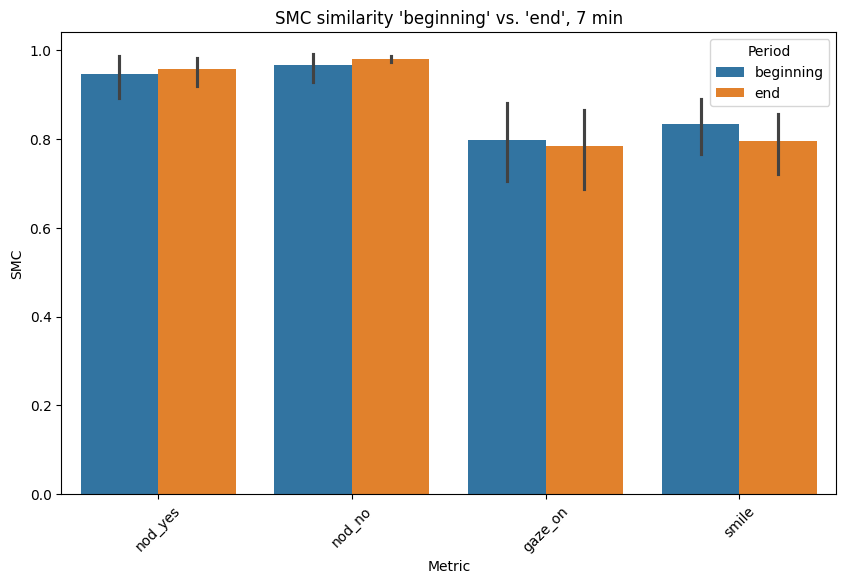

In [101]:
# Bar Plot for SMC Similarities
smc_melted = pd.melt(jaccard_df, id_vars=['video', 'period'], value_vars=['nod_yes', 'nod_no', 'gaze_on', 'smile'], var_name='metric', value_name='smc_similarity')
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='smc_similarity', hue='period', data=smc_melted)
plt.title("SMC similarity 'beginning' vs. 'end', 7 min")
plt.xlabel('Metric')
plt.ylabel('SMC')
plt.xticks(rotation=45)
plt.legend(title='Period')

# McNemar

In [32]:
from statsmodels.stats.contingency_tables import mcnemar

# Filter increase between beginning and end
increased_similarity = smc_melted.groupby(['video', 'metric']).apply(lambda x: x.iloc[1]['smc_similarity'] > x.iloc[0]['smc_similarity'])
# Get videos with increase
videos_metrics_with_increased_similarity = increased_similarity[increased_similarity].index

significance = {}

res = []

# Perform McNemar test for each video and metric pair
for i, metric in videos_metrics_with_increased_similarity:
    vid_begin = windows_head[i-1]['beginning']
    vid_end = windows_head[i-1]['end']

    bob_beginning_array = vid_begin[vid_begin['user_id'] == 'Bob'][metric]
    joe_beginning_array = vid_begin[vid_begin['user_id'] == 'Joe'][metric]
    begin = np.concatenate((bob_beginning_array, joe_beginning_array))

    bob_end_array = vid_end[vid_end['user_id'] == 'Bob'][metric]
    joe_end_array = vid_end[vid_end['user_id'] == 'Joe'][metric]
    end = np.concatenate((bob_end_array, joe_end_array))

    df = pd.DataFrame({'begin': begin, 'end': end})
    cross_tab = pd.crosstab(df['begin'], df['end'])

    if cross_tab.shape == (2,2):
        result = mcnemar(cross_tab)
        significance[(i, metric)] = result.pvalue
    else:
        print("not 2x2")


/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/1728215365.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  increased_similarity = smc_melted.groupby(['video', 'metric']).apply(lambda x: x.iloc[1]['smc_similarity'] > x.iloc[0]['smc_similarity'])


not 2x2
not 2x2
not 2x2


In [33]:
significance_df = pd.DataFrame.from_dict(significance, orient='index', columns=['p_value'])
significant_videos = significance_df[significance_df['p_value'] < 0.05]
significant_videos

p_value
(1, nod_yes)   4.308570e-04
(2, smile)     1.015744e-16
(3, gaze_on)   1.475074e-06
(3, nod_no)    3.326893e-03
(6, smile)     6.550303e-04
(14, nod_yes)  1.045482e-02
(14, smile)    2.460450e-31
(16, nod_no)   6.802593e-10
(16, smile)    4.580326e-11
(19, smile)    4.566611e-07
(24, nod_no)   1.277460e-02
(27, gaze_on)  9.883473e-09
(27, nod_no)   9.143907e-04
(29, smile)    6.900699e-06
(40, nod_yes)  4.980011e-02
(41, gaze_on)  1.718056e-13
(43, gaze_on)  1.719691e-05
(45, smile)    1.852533e-11
(46, gaze_on)  2.691034e-03
(46, nod_yes)  3.188679e-03
(46, smile)    9.230901e-08
(48, gaze_on)  2.316430e-05
(48, smile)    3.540008e-17
(49, gaze_on)  3.107488e-04
(49, nod_yes)  3.088379e-02
(53, smile)    4.330281e-34
(54, gaze_on)  2.493970e-26
(54, nod_yes)  7.172697e-04
(54, smile)    1.266675e-32

In [34]:
import pandas as pd

# Assuming significant_videos is the DataFrame containing the data
# Convert index to a DataFrame column
significant_videos.reset_index(inplace=True)
significant_videos.columns = ['video_metric', 'p_value']
total_rows = len(significant_videos)
smile_rows = significant_videos[significant_videos['video_metric'].apply(lambda x: x[1] == 'smile')]
smile_rows_count = len(smile_rows)
percentage_smile_rows = (smile_rows_count / total_rows) * 100

print("Percentage of rows where the metric is 'smile': {:.2f}%".format(percentage_smile_rows))

Percentage of rows where the metric is 'smile': 37.93%


# Chi Square Hypothesis Test

In [35]:
from scipy.stats import chi2_contingency
from collections import defaultdict

# Define dictionaries to store results
chi2_results = {}
phi_coefficient_changes = {}
periods = ['beginning', 'end']

# Iterate through each row in the significant_videos DataFrame
for index, row in significant_videos.iterrows():
    video_index = row[0][0]
    metric = row[0][1]

    vid_beginning = vid_beginning = windows_head[video_index]['beginning']
    metric_s1_beginning = [label for label in vid_beginning[vid_beginning['user_id'] == 'Bob'][metric]]
    metric_s2_beginning = [label for label in vid_beginning[vid_beginning['user_id'] == 'Joe'][metric]]
    data_beginning = pd.DataFrame({'metric_s1': metric_s1_beginning, 'metric_s2': metric_s2_beginning})

    contingency_table_beginning = pd.crosstab(data_beginning['metric_s1'], data_beginning['metric_s2'], dropna=False)
    chi2_beginning, p_val_beginning, _, _ = chi2_contingency(contingency_table_beginning, correction=True)

    if contingency_table_beginning.shape == (2,2):
        a_beginning = contingency_table_beginning.iloc[0, 0]
        b_beginning = contingency_table_beginning.iloc[0, 1]
        c_beginning = contingency_table_beginning.iloc[1, 0]
        d_beginning = contingency_table_beginning.iloc[1, 1]

        phi_coefficient_beginning = (a_beginning * d_beginning - b_beginning * c_beginning) / \
                                        np.sqrt((a_beginning + b_beginning) * (c_beginning + d_beginning) * \
                                                (a_beginning + c_beginning) * (b_beginning + d_beginning))
    else:
        phi_coefficient_beginning = 0
    
    vid_end = vid_end = windows_head[video_index]['end']
    metric_s1_end = [label for label in vid_end[vid_end['user_id'] == 'Bob'][metric]]
    metric_s2_end = [label for label in vid_end[vid_end['user_id'] == 'Joe'][metric]]
    data_end = pd.DataFrame({'metric_s1': metric_s1_end, 'metric_s2': metric_s2_end})

    contingency_table_end = pd.crosstab(data_end['metric_s1'], data_end['metric_s2'], dropna=False)
    chi2_end, p_val_end, _, _ = chi2_contingency(contingency_table_end, correction=True)

    if contingency_table_end.shape == (2,2):
        a_end = contingency_table_end.iloc[0, 0]
        b_end = contingency_table_end.iloc[0, 1]
        c_end = contingency_table_end.iloc[1, 0]
        d_end = contingency_table_end.iloc[1, 1]
        phi_coefficient_end = (a_end * d_end - b_end * c_end) / \
                            np.sqrt((a_end + b_end) * (c_end + d_end) * (a_end + c_end) * (b_end + d_end))
    else:
        phi_coefficient_end = 0
    
    chi2_results[(video_index + 1, 'beginning_pval', metric)] = p_val_beginning
    chi2_results[(video_index + 1, 'end_pval', metric)] = p_val_end

    phi_coefficient_changes[(video_index + 1, metric)] = phi_coefficient_end - phi_coefficient_beginning

# Calculate change in phi coefficient between periods
# phi_coefficient_change = {}
# for i in range(1, len(significant_videos) + 1):
#     phi_coefficient_change[i] = phi_coefficient_changes[i * 2] - phi_coefficient_changes[(i * 2) - 1]

# # Display or save results as needed
# print("Chi-square test p-values for each video and period:")
# print(chi2_results)
# print("\nChange in phi coefficient between periods for each video:")
# print(phi_coefficient_change)


/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/104338280.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  video_index = row[0][0]
/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/104338280.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metric = row[0][1]
/var/folders/3p/j_x44c2s1g9cmby7tjycr9vh0000gn/T/ipykernel_72206/104338280.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  video_ind

In [36]:
print("Chi-square test p-values for each video, period, and metric:")
print(chi2_results)
print("\nChange in phi coefficient between 'beginning' and 'end' periods for each video and metric:")
print(phi_coefficient_changes)

Chi-square test p-values for each video, period, and metric:
{(2, 'beginning_pval', 'nod_yes'): 1.0, (2, 'end_pval', 'nod_yes'): 1.0, (3, 'beginning_pval', 'smile'): 0.698906555875595, (3, 'end_pval', 'smile'): 0.03255917837968458, (4, 'beginning_pval', 'gaze_on'): 0.15494807584466636, (4, 'end_pval', 'gaze_on'): 1.0, (4, 'beginning_pval', 'nod_no'): 1.0, (4, 'end_pval', 'nod_no'): 0.4707746498620885, (7, 'beginning_pval', 'smile'): 1.0, (7, 'end_pval', 'smile'): 0.14210789231312082, (15, 'beginning_pval', 'nod_yes'): 1.0, (15, 'end_pval', 'nod_yes'): 1.0, (15, 'beginning_pval', 'smile'): 1.0, (15, 'end_pval', 'smile'): 1.0, (17, 'beginning_pval', 'nod_no'): 0.8833621722122412, (17, 'end_pval', 'nod_no'): 1.0, (17, 'beginning_pval', 'smile'): 0.6995639379118954, (17, 'end_pval', 'smile'): 0.2691568989801313, (20, 'beginning_pval', 'smile'): 1.0, (20, 'end_pval', 'smile'): 1.0, (25, 'beginning_pval', 'nod_no'): 1.0, (25, 'end_pval', 'nod_no'): 0.4801785990197711, (28, 'beginning_pval', 

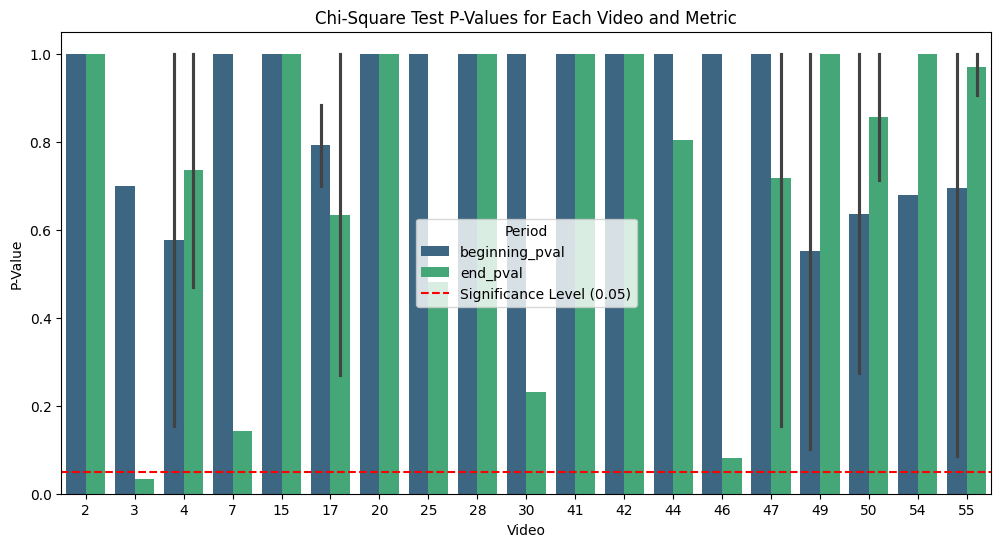

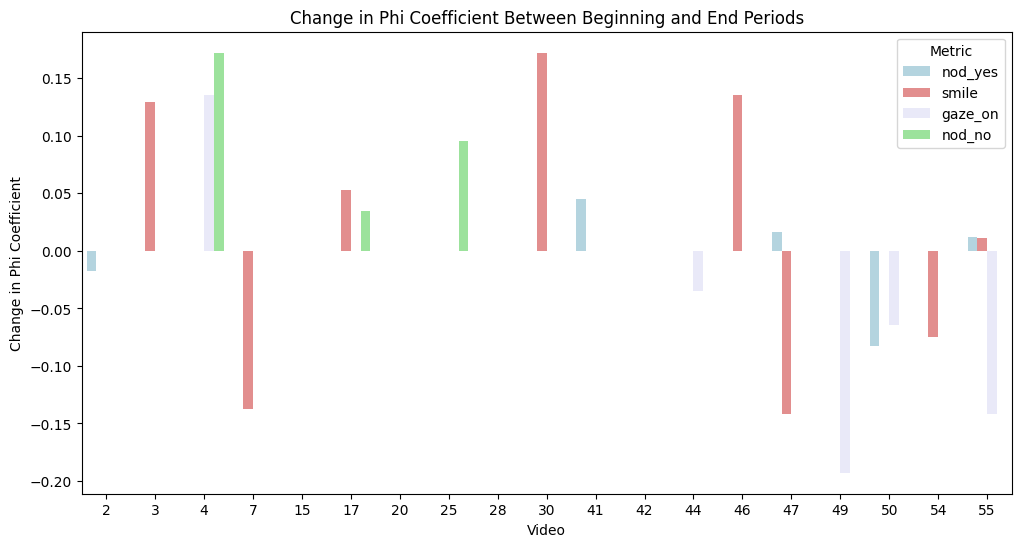

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert chi2_results and phi_coefficient_changes to DataFrame for easier plotting
chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['p_value']).reset_index()
chi2_results_df[['video', 'period', 'metric']] = pd.DataFrame(chi2_results_df['index'].tolist(), index=chi2_results_df.index)
chi2_results_df = chi2_results_df.drop(columns=['index'])

phi_coefficient_changes_df = pd.DataFrame.from_dict(phi_coefficient_changes, orient='index', columns=['phi_change']).reset_index()
phi_coefficient_changes_df[['video', 'metric']] = pd.DataFrame(phi_coefficient_changes_df['index'].tolist(), index=phi_coefficient_changes_df.index)
phi_coefficient_changes_df = phi_coefficient_changes_df.drop(columns=['index'])

# Plotting Chi-Square Test P-Values
plt.figure(figsize=(12, 6))
sns.barplot(x='video', y='p_value', hue='period', data=chi2_results_df, palette='viridis')
plt.title('Chi-Square Test P-Values for Each Video and Metric')
plt.xlabel('Video')
plt.ylabel('P-Value')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.legend(title='Period')
plt.show()

metric_color_map = {
    'nod_yes': 'lightblue',
    'nod_no': 'lightgreen',
    'smile': 'lightcoral',
    'gaze_on': 'lavender',
}

# Extract unique metrics from phi_coefficient_changes_df
unique_metrics = phi_coefficient_changes_df['metric'].unique()

# Create a custom color palette using the specified colors for each metric
custom_palette = [metric_color_map[metric] for metric in unique_metrics]

# Plotting Change in Phi Coefficient
plt.figure(figsize=(12, 6))
sns.barplot(x='video', y='phi_change', hue='metric', data=phi_coefficient_changes_df, palette=custom_palette)
plt.title('Change in Phi Coefficient Between Beginning and End Periods')
plt.xlabel('Video')
plt.ylabel('Change in Phi Coefficient')
plt.legend(title='Metric')
plt.show()


# Combined Test

### Dependencies

In [38]:
from scipy.spatial import distance
from scipy.stats import chi2_contingency
from collections import defaultdict
from statsmodels.stats.contingency_tables import mcnemar

### SMC Similarity

In [39]:
''' SMC SIMILARITY '''
# Calculate Jaccard similarities
smc_data = []
for idx, video in enumerate(windows_head):
    for period in ['beginning', 'end']:
        nod_yes_bob = video[period][video[period]['user_id'] == 'Bob']['nod_yes']
        nod_no_bob = video[period][video[period]['user_id'] == 'Bob']['nod_no']
        gaze_on_bob = video[period][video[period]['user_id'] == 'Bob']['gaze_on']
        smile_bob = video[period][video[period]['user_id'] == 'Bob']['smile']

        nod_yes_joe = video[period][video[period]['user_id'] == 'Joe']['nod_yes']
        nod_no_joe = video[period][video[period]['user_id'] == 'Joe']['nod_no']
        gaze_on_joe = video[period][video[period]['user_id'] == 'Joe']['gaze_on']
        smile_joe = video[period][video[period]['user_id'] == 'Joe']['smile']

        smc_nod_yes = distance.jaccard(nod_yes_bob, nod_yes_joe)
        smc_nod_no = distance.jaccard(nod_no_bob, nod_no_joe)
        smc_gaze_on = distance.jaccard(gaze_on_bob, gaze_on_joe)
        smc_smile = distance.jaccard(smile_bob, smile_joe)

        smc_data.append({
            'video': idx + 1,
            'period': period,
            'nod_yes': smc_nod_yes,
            'nod_no': smc_nod_no,
            'gaze_on': smc_gaze_on,
            'smile': smc_smile
        })

# Convert Jaccard data to DataFrame
smc_df = pd.DataFrame(smc_data)

# Calculate differences between beginning and end Jaccard similarities
differences = []

for video in smc_df['video'].unique():
    beginning = smc_df[(smc_df['video'] == video) & (smc_df['period'] == 'beginning')]
    end = smc_df[(smc_df['video'] == video) & (smc_df['period'] == 'end')]
    
    differences.append({
        'video': video,
        'diff_nod_yes': end['nod_yes'].values[0] - beginning['nod_yes'].values[0],
        'diff_nod_no': end['nod_no'].values[0] - beginning['nod_no'].values[0],
        'diff_gaze_on': end['gaze_on'].values[0] - beginning['gaze_on'].values[0],
        'diff_smile': end['smile'].values[0] - beginning['smile'].values[0]
    })

differences_df = pd.DataFrame(differences)
differences_df.head()

video  diff_nod_yes  diff_nod_no  diff_gaze_on  diff_smile
0      1      0.030303     0.000000     -0.033058   -0.105533
1      2      0.000000     0.000000     -0.070465    0.413487
2      3      0.000000     0.086957      0.178524   -0.139524
3      4      0.000000    -0.090909     -0.100075   -0.156642
4      5      0.000000    -0.023256      0.000000    0.006452

### McNemar

In [40]:
''' MCNEMAR TEST '''
# Perform correlation, smc similarity analysis, and mcnemar
mc_nemar_results = []
metrics = ['gaze_on', 'nod_yes', 'nod_no', 'smile']
# Perform McNemar test for each video and metric pair
for metric in metrics:
    for i in range(len(windows_head)):
        vid_begin = windows_head[i]['beginning']
        vid_end = windows_head[i]['end']    
        bob_beginning_array = vid_begin[vid_begin['user_id'] == 'Bob'][metric]
        joe_beginning_array = vid_begin[vid_begin['user_id'] == 'Joe'][metric]
        begin = np.concatenate((bob_beginning_array, joe_beginning_array))
        bob_end_array = vid_end[vid_end['user_id'] == 'Bob'][metric]
        joe_end_array = vid_end[vid_end['user_id'] == 'Joe'][metric]
        end = np.concatenate((bob_end_array, joe_end_array))

        df = pd.DataFrame({'begin': begin, 'end': end})
        cross_tab = pd.crosstab(df['begin'], df['end'])
        cross_tab = cross_tab.reindex(index=[0, 1], columns=[0, 1], fill_value=0)
        result = mcnemar(cross_tab)

        # Save results
        mc_nemar_results.append({
            'video': i,
            'metric': metric,
            'statistic': result.statistic,
            'p_value': result.pvalue
        })

# Create DataFrame from results
mcnemar_df = pd.DataFrame(mc_nemar_results)
mcnemar_df.head()

video   metric  statistic   p_value
0      0  gaze_on       26.0  0.031927
1      1  gaze_on       76.0  0.043871
2      2  gaze_on       60.0  0.000001
3      3  gaze_on       96.0  0.572676
4      4  gaze_on        2.0  0.289062

### Chi Squared Test

In [41]:
correlation_stats_internal = {
    'beginning': defaultdict(lambda: defaultdict(int)),
    'end': defaultdict(lambda: defaultdict(int))
}

metrics = ['gaze_on', 'nod_yes', 'nod_no', 'smile']
results_chi = []

for idx, video in enumerate(windows_head):
    for period in ['beginning', 'end']:
        for i, metric1 in enumerate(metrics):
            for j, metric2 in enumerate(metrics):
                metric_s1 = [label for label in video[period][video[period]['user_id'] == 'Bob'][metric1]]
                metric_s2 = [label for label in video[period][video[period]['user_id'] == 'Joe'][metric2]]
                data = pd.DataFrame({'metric_s1': metric_s1, 'metric_s2': metric_s2})
                contingency_table = pd.crosstab(data['metric_s1'], data['metric_s2'], dropna=False)
                if contingency_table.shape == (2,2):
                    chi2, p_val, dof, _ = chi2_contingency(contingency_table, correction=True)
                    a = contingency_table.iloc[0, 0]
                    b = contingency_table.iloc[0, 1]
                    c = contingency_table.iloc[1, 0]
                    d = contingency_table.iloc[1, 1]

                    if (np.sqrt((a + b) * (c + d) * (a + c) * (b + d))) != 0:
                        phi_coefficient = (a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
                    else:
                        phi_coefficient = np.nan

                results_chi.append({
                    'video': idx,
                    'period': period,
                    'metric1': metric1,
                    'metric2': metric2,
                    'p_val': p_val,
                    'phi_coefficient': phi_coefficient
                })

# Convert results to DataFrame
results_chi_df = pd.DataFrame(results_chi)
results_chi_df.head()

video     period  metric1  metric2     p_val  phi_coefficient
0      0  beginning  gaze_on  gaze_on  0.475121        -0.144591
1      0  beginning  gaze_on  nod_yes  0.673149         0.077494
2      0  beginning  gaze_on   nod_no  0.673149         0.077494
3      0  beginning  gaze_on    smile  0.884233        -0.039213
4      0  beginning  nod_yes  gaze_on  1.000000        -0.016028

### Final df

In [42]:
final_df = differences_df.merge(mcnemar_df, left_on='video', right_on='video', how='left').merge(results_chi_df, left_on='video', right_on='video', how='left')
final_df.head()

video  diff_nod_yes  diff_nod_no  diff_gaze_on  diff_smile   metric  \
0      1      0.030303          0.0     -0.033058   -0.105533  gaze_on   
1      1      0.030303          0.0     -0.033058   -0.105533  gaze_on   
2      1      0.030303          0.0     -0.033058   -0.105533  gaze_on   
3      1      0.030303          0.0     -0.033058   -0.105533  gaze_on   
4      1      0.030303          0.0     -0.033058   -0.105533  gaze_on   

   statistic   p_value     period  metric1  metric2     p_val  phi_coefficient  
0       76.0  0.043871  beginning  gaze_on  gaze_on  0.008883        -0.206223  
1       76.0  0.043871  beginning  gaze_on  nod_yes  0.008883        -0.206223  
2       76.0  0.043871  beginning  gaze_on   nod_no  0.656721         0.086904  
3       76.0  0.043871  beginning  gaze_on    smile  0.981442        -0.014246  
4       76.0  0.043871  beginning  nod_yes  gaze_on  1.000000        -0.055795

# Visualization

Text(0.5, 1.0, 'Aggregated Phi Coefficients - 3 min windows')

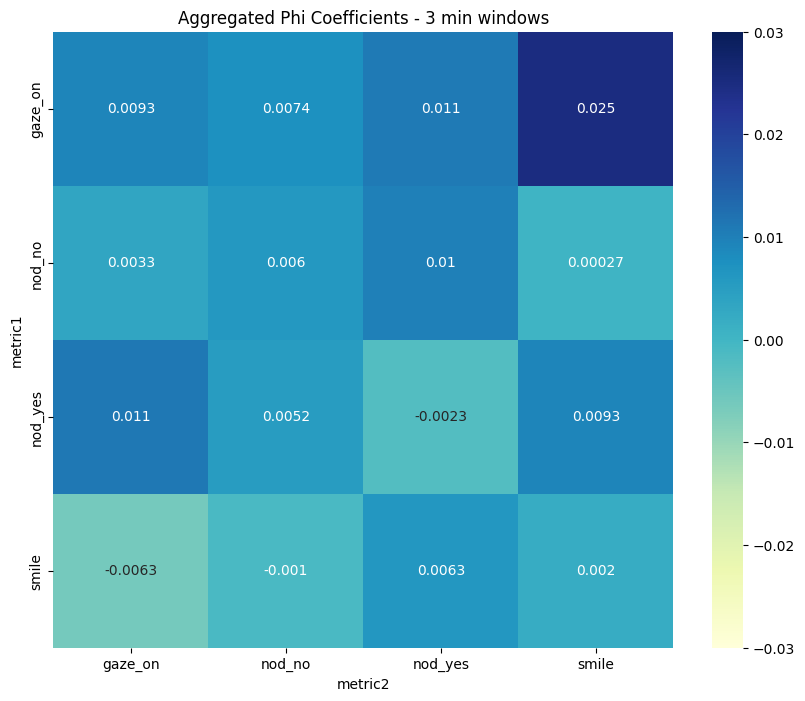

In [43]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Heatmap for Correlation Analysis
# vmin = -0.03
# vmax = 0.03
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     results_chi_df.pivot_table(index='metric1', columns='metric2', values='phi_coefficient'),
#     annot=True,
#     cmap="YlGnBu",
#     vmin=vmin,
#     vmax=vmax
# )
# plt.title('Aggregated Phi Coefficients - 3 min windows')

# Correlation Phi Significant

In [95]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Filter the results_df to include only significant correlations
# significant_results = results_chi_df[results_chi_df['p_val'] < 0.05]

# if not significant_results.empty:
#     phi_matrix = significant_results.pivot_table(index='metric1', columns='metric2', values='phi_coefficient', aggfunc=np.mean)
#     phi_matrix = phi_matrix.fillna(0)
#     vmin = -0.31  
#     vmax = 0.31  
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(phi_matrix, annot=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)
#     plt.title('Phi Coefficient Correlation Matrix (Significant Correlations)')
#     plt.show()
# else:
#     print("No significant correlations found.")